# Prediction of number of days an animal (dog-cat) will spend in the shelter before being addopted.

# Table of Contents
1. [Data cleaning and preparation](#1)
2. [EDA](#2)
3. [Model evaluation](#3)   
    3.1 [Features selection](#31)  
    3.2 [Training models](#32)  
        - 3.2.1 [Linear Regression](#321)  
        - 3.2.2 [Random Forest](#322)


In [135]:
import requests
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.feature_extraction import DictVectorizer
from collections import Counter
from itertools import combinations
from sklearn.linear_model import LinearRegression
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score
from xgboost import XGBRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, r2_score



In [136]:
# read prepared dataset
df = pd.DataFrame(pd.read_csv('data.csv'))

<h2 id="1">1. Data cleaning and preparation</h2>


Dataframe from source

In [137]:
df.head().T

,0,1,2,3,4
animal_id,A844350,A818975,A760053,A707375,A696408
name,*Ella,NaN,NaN,*Candy Cane,*Pearl
datetime_intake,2021-10-15 11:40:00,2020-06-18 14:53:00,2017-10-11 15:46:00,2015-07-11 18:19:00,2015-02-04 12:58:00
found_location,2112 East William Cannon Drive in Austin (TX),Braker Lane And Metric in Travis (TX),8800 South First Street in Austin (TX),Galilee Court And Damita Jo Dr in Manor (TX),9705 Thaxton in Austin (TX)
intake_type,Stray,Stray,Stray,Stray,Stray
intake_condition,Normal,Normal,Normal,Normal,Normal
animal_type,Cat,Cat,Dog,Dog,Dog
sex_upon_intake,Intact Female,Intact Male,Intact Male,Intact Female,Intact Female
age_upon_intake,6 months,4 weeks,2 years,5 months,2 years
breed,Domestic Shorthair,Domestic Shorthair,Chihuahua Shorthair,Pit Bull,Chihuahua Shorthair


In [138]:
df.dtypes


animal_id           object
name                object
datetime_intake     object
found_location      object
intake_type         object
intake_condition    object
animal_type         object
sex_upon_intake     object
age_upon_intake     object
breed               object
color               object
datetime_outcome    object
outcome_type        object
dtype: object

#### 1.1 Data types & formats inside df

In [139]:
# datetime columns: datetime_intake, datetime_outcome
datetime_columns = ['datetime_intake', 'datetime_outcome']
# convert the datetime columns to datetime type
for column in datetime_columns:
    df[column] = pd.to_datetime(df[column])
datetime_columns

['datetime_intake', 'datetime_outcome']

In [140]:
# rest of the columns from dataframe that are not datetime categorical columns
categorical_columns = df.select_dtypes(include=['object']).columns.tolist()
categorical_columns

for column in categorical_columns:
    df[column] = df[column].str.lower()

#### 1.2 Target outcome calculation: days in the shelter.

In [141]:
# lets calculate our target variable
# the target variable is the difference between the datetime_outcome and datetime_intake
df['days_in_shelter'] = (df['datetime_outcome'] - df['datetime_intake']).dt.days

#### 1.3 Feature transformation: Clean categories with a lot of unique values

In [142]:
for column in categorical_columns:
    print(f'{column}: {df[column].nunique()} unique values')
    

animal_id: 72209 unique values
name: 19337 unique values
found_location: 32015 unique values
intake_type: 5 unique values
intake_condition: 14 unique values
animal_type: 2 unique values
sex_upon_intake: 5 unique values
age_upon_intake: 47 unique values
breed: 2066 unique values
color: 475 unique values
outcome_type: 1 unique values


- Divide the sex upon intake into sex and castrated status

In [143]:
def castrated_status(row):
    if 'neutered' in row or 'spayed' in row:
        return 'yes'
    else:
        return 'no'

def sex_upon_intake(row):
    if 'female' in row:
        return 'female'
    elif 'male' in row:
        return 'male'
    else:
        return 'unknown'

df['castrated'] = df['sex_upon_intake'].apply(castrated_status)
df['sex_upon_intake'] = df['sex_upon_intake'].apply(sex_upon_intake) 


- Convert age_upon_intake in months 

In [144]:
df.age_upon_intake.value_counts().head()

age_upon_intake
1 month     12725
1 year      11595
2 years     10709
2 months     7730
3 years      3702
Name: count, dtype: int64

In [145]:
def convert_to_months(age):
    # Split the age into value and unit
    parts = age.split()
    if len(parts) != 2:  # Handle unexpected formats
        return None
    
    value, unit = int(parts[0]), parts[1].lower()
    
    # Convert the age to months
    if 'year' in unit:
        return value * 12
    elif 'month' in unit:
        return value 
    elif 'week' in unit:
        return value / 4
    elif 'day' in unit:
        return value / 30
    else:
        return None  # Handle unknown units

# Apply the function to the column and create a new column
df['age_in_months'] = df['age_upon_intake'].apply(convert_to_months)

# Check the resulting DataFrame
print(df[['age_upon_intake', 'age_in_months']].head())


  age_upon_intake  age_in_months
0        6 months            6.0
1         4 weeks            1.0
2         2 years           24.0
3        5 months            5.0
4         2 years           24.0


In [146]:
print(df['age_in_months'].describe())


count    79570.000000
mean        18.051550
std         27.911971
min        -48.000000
25%          1.000000
50%          7.000000
75%         24.000000
max        240.000000
Name: age_in_months, dtype: float64


we can see animals with ages below 0. Lets look at them

In [147]:
df[df['age_in_months']<0]   


,animal_id,name,datetime_intake,found_location,intake_type,intake_condition,animal_type,sex_upon_intake,age_upon_intake,breed,color,datetime_outcome,outcome_type,days_in_shelter,castrated,age_in_months
4384,a725472,rascal,2019-02-26 11:25:00,austin (tx),owner surrender,normal,dog,male,-1 years,chihuahua shorthair mix,white/brown,2019-02-26 14:34:00,adoption,0,yes,-12.0
12699,a725472,rascal,2016-06-12 14:16:00,austin (tx),owner surrender,aged,dog,male,-3 years,chihuahua shorthair mix,white/brown,2016-07-24 15:54:00,adoption,42,yes,-36.0
20142,a783723,pina,2018-11-05 11:00:00,3108 crownover street in austin (tx),stray,normal,cat,female,-4 years,domestic shorthair,white/orange,2018-11-12 11:53:00,adoption,7,no,-48.0


as I assume there are errors, I will remove the -

In [148]:
# remove from age the ¨-¨ character
df['age_in_months'] = df['age_in_months'].abs()

In [149]:
df['age_in_months'].describe()

count    79570.000000
mean        18.053963
std         27.910410
min          0.000000
25%          1.000000
50%          7.000000
75%         24.000000
max        240.000000
Name: age_in_months, dtype: float64

* Breed

In [150]:
df['breed'].value_counts().head()

breed
domestic shorthair mix     15460
domestic shorthair         12496
labrador retriever mix      4726
pit bull mix                4230
chihuahua shorthair mix     3279
Name: count, dtype: int64

In [151]:
# Split the breed column into individual words
all_words = df['breed'].str.split(expand=True).stack()
word_counts = Counter(all_words)
 
word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
percentage_limit = 80 # I decided to use 80% as the limit to cover the most important words
total_words = word_freq_df['Frequency'].sum()
word_freq_df['Percentage'] = (word_freq_df['Frequency'] / total_words) * 100
word_freq_df = word_freq_df.sort_values(by='Percentage', ascending=False)
word_freq_df['Cumulative Percentage'] = word_freq_df['Percentage'].cumsum()
important_words_df = word_freq_df[word_freq_df['Cumulative Percentage'] <= percentage_limit]
 
print(f"Important Words in Breeds (% {percentage_limit} Cumulative Importance):")
print(important_words_df)


Important Words in Breeds (% 80 Cumulative Importance):
          Word  Frequency  Percentage  Cumulative Percentage
5          mix      48313   22.501618              22.501618
1    shorthair      32965   15.353339              37.854957
0     domestic      32106   14.953262              52.808219
11   retriever       7250    3.376663              56.184883
12    labrador       7214    3.359896              59.544779
4         bull       6830    3.181050              62.725829
3          pit       6587    3.067873              65.793702
2    chihuahua       5232    2.436787              68.230489
29    shepherd       5003    2.330131              70.560619
28      german       3970    1.849014              72.409634
15     terrier       3393    1.580278              73.989912
39        hair       2937    1.367898              75.357810
8   australian       2853    1.328775              76.686585
38      medium       2846    1.325515              78.012100
9       cattle       2183    

In the table above we can see the words inside breeds that appears in 80% of the records.  
There are somo common properties that would be separated creating more features: 
* extract the hairtype in another column
* separate the mix as separate propertie
* separate miniature
* separate domestic

In [152]:
# 'hair_type'
df['hair_type'] = df['breed'].apply(
    lambda x: 'long' if 'longhair' in x else 'short' if 'shorthair' in x
      else 'medium' if 'medium hair' in x else 'unknown')

df['hair_type'].value_counts()


hair_type
unknown    41214
short      33623
medium      2846
long        1887
Name: count, dtype: int64

In [153]:
# mix breed column
df['mix_breed'] = df['breed'].apply(lambda x: 'mix' if 'mix' in x else 'not mix')

In [154]:
# miniature breed column
df['miniature'] = df['breed'].apply(lambda x: 'miniature' if 'miniature' in x else 'non-miniature')

In [155]:
# domestic breed column
df['domestic'] = df['breed'].apply(lambda x: 'domestic' if 'domestic' in x else 'non-domestic')

After creating these features, let's remove these wordsd from the breed column

In [156]:
words_to_remove = ['mix', 'shorthair', 'longhair', 'medium hair', 'miniature', 'domestic','dog','cat']
for word in words_to_remove:
    df['breed'] = df['breed'].str.replace(word, '').str.strip()

Get the pair combinations of names inside breed so as to identify common ones.

In [157]:
# Tokenize each row in the breed column
df['breed_tokenized'] = df['breed'].str.split()
word_pairs = df['breed_tokenized'].apply(lambda x: list(combinations(x, 2)))

all_pairs = [pair for pairs in word_pairs for pair in pairs]

pair_counts = Counter(all_pairs)
pair_freq_df = pd.DataFrame(pair_counts.items(), columns=['Pair', 'Frequency']).sort_values(by='Frequency', ascending=False)
total_pairs = pair_freq_df['Frequency'].sum()
pair_freq_df['Percentage'] = (pair_freq_df['Frequency'] / total_pairs) * 100
pair_freq_df['Cumulative Percentage'] = pair_freq_df['Percentage'].cumsum()

target_percentage = 0.8  # I decided to use 80% as the limit to cover the most important pairs
frequent_pairs_df = pair_freq_df[pair_freq_df['Percentage'] >= target_percentage]
print("Frequent Word Pairs with Running Percentage:")
print(frequent_pairs_df)

Frequent Word Pairs with Running Percentage:
                       Pair  Frequency  Percentage  Cumulative Percentage
0               (pit, bull)       6201   11.665444              11.665444
8     (labrador, retriever)       5738   10.794439              22.459883
17       (german, shepherd)       3246    6.106439              28.566322
2         (australian, tle)       1824    3.431345              31.997667
12        (siberian, husky)        946    1.779634              33.777301
62         (border, collie)        754    1.418440              35.195741
24         (american, bull)        695    1.307448              36.503189
54   (australian, shepherd)        600    1.128732              37.631921
21        (great, pyrenees)        589    1.108038              38.739959
97          (jack, russell)        555    1.044077              39.784036
99       (russell, terrier)        534    1.004571              40.788607
25      (american, terrier)        492    0.925560              41.

Assign the most frequent combinations to a new property called breed_group1

In [158]:
# Ensure the breed column and frequent pairs are processed correctly
def assign_breed_group(breed, frequent_pairs):
    for pair in frequent_pairs:
        if all(word in breed for word in pair):
            return f"{pair[0]}_{pair[1]}"
    return None

# Apply the function to the DataFrame
df['breed_group1'] = df['breed'].apply(lambda x: assign_breed_group(x, frequent_pairs_df['Pair'].tolist()))
df['breed_group1'].value_counts()

breed_group1
labrador_retriever     8087
pit_bull               7135
german_shepherd        3996
australian_tle         1851
siberian_husky         1041
border_collie           972
great_pyrenees          708
australian_shepherd     612
jack_russell            592
black_mouth             477
american_bull           395
american_terrier        204
russell_terrier          29
Name: count, dtype: int64

After checking the combinations, lets see which repeated words remain there (removing the combinations from the breed before)

In [159]:
top_combinations = frequent_pairs_df['Pair'].tolist()

def remove_combinations(breed, combinations):
    for pair in combinations:
        if all(word in breed for word in pair):
            breed = breed.replace(f"{pair[0]} {pair[1]}", "")
    return breed.strip()

# Apply the function to clean up the breed column
df['breed'] = df['breed'].apply(lambda x: remove_combinations(x, top_combinations))

# after cleaning the breed column, we can re-calculate the frequent words
df_no_breed_group = df[df['breed_group1'].isna()]

all_words = df_no_breed_group['breed'].str.split(expand=True).stack()
word_counts = Counter(all_words)


word_freq_df = pd.DataFrame(word_counts.items(), columns=['Word', 'Frequency']).sort_values(by='Frequency', ascending=False)
percentage_limit = 2 # I decided to use 2% as the limit to cover the most important words
total_words = word_freq_df['Frequency'].sum()
word_freq_df['Percentage'] = (word_freq_df['Frequency'] / total_words) * 100
word_freq_df = word_freq_df.sort_values(by='Percentage', ascending=False)
word_freq_df['Cumulative Percentage'] = word_freq_df['Percentage'].cumsum()
frequent_words_df = word_freq_df[word_freq_df['Percentage'] >= percentage_limit]

print(f"Frequent Words in Breeds (% {percentage_limit}  Importance):")
print(frequent_words_df)

Frequent Words in Breeds (% 2  Importance):
         Word  Frequency  Percentage  Cumulative Percentage
0   chihuahua       5170   16.182040              16.182040
5     terrier       2292    7.173933              23.355974
38    siamese       1034    3.236408              26.592382
34  dachshund        904    2.829510              29.421891
76      hound        804    2.516511              31.938402
11     poodle        704    2.203512              34.141914
54      boxer        693    2.169082              36.310996


These are the most relevant words in breeds that have more than 2% of the records.

In [160]:
exclude_words = ['bull', 'pit'] 
frequent_words_df = frequent_words_df[~frequent_words_df['Word'].isin(exclude_words)]

Assign the most repeated words as breed_group2

In [161]:
# Ensure the breed column and frequent pairs are processed correctly
def assign_breed_word(breed, frequent_words):
    for word in frequent_words:
        if word in breed:
            return word
    return None
# Apply the function to the DataFrame
df['breed_group2'] = df['breed'].apply(lambda x: assign_breed_word(x, frequent_words_df['Word'].tolist()))

df['breed_group2'].value_counts()

breed_group2
chihuahua    5908
terrier      3478
hound        1439
dachshund    1112
boxer        1101
siamese      1054
poodle        725
Name: count, dtype: int64

Merge breed_group1 & breed_group2 (using coalesce and prioritizing the combinations)

In [162]:
df['breed_group'] = df['breed_group1'].fillna(df['breed_group2'])

# assign the breed_group to other if it is still null
df['breed_group'] = df['breed_group'].fillna('Other')

* Color

In [163]:
color_combinations = df['color'].str.split('/') # Split the color column by '/'
split_colors = color_combinations.apply(lambda x: [part.split()[0] for part in x] if isinstance(x, list) else []) # get the first word of each component

df['color_primary'] = split_colors.apply(lambda x: x[0] if len(x) > 0 else None)  # First color
df['color_secondary'] = split_colors.apply(lambda x: x[1] if len(x) > 1 else None)  # Second color

# single-color groups
single_colors = df[df['color_secondary'].isnull()]['color_primary'] # get single-color records

percentage_limit  = 0.05
single_color_counts = single_colors.value_counts()
total_single = single_colors.count()
dominant_single_colors = single_color_counts[single_color_counts / total_single >percentage_limit].index

df['single_color_group'] = df['color_primary'].apply(
    lambda x: x if x in dominant_single_colors else 'other_single_colour'
) 

# two-color combinations
df['sorted_combination'] = df.apply(
    lambda row: tuple(sorted([row['color_primary'], row['color_secondary']]))
    if pd.notnull(row['color_secondary']) else None,
    axis=1
)

percentage_limit_combinations = 0.05
combination_counts = df['sorted_combination'].dropna().value_counts()
total_combinations = combination_counts.sum()
dominant_combinations = combination_counts[combination_counts / total_combinations > percentage_limit_combinations].index

df['combination_group'] = df['sorted_combination'].apply(
    lambda x: x if x in dominant_combinations else 'other_multiple_color'
) 

# final color group assignment
df['color_group'] = df.apply(
    lambda row: row['single_color_group']
    if pd.isnull(row['sorted_combination'])
    else row['combination_group'],
    axis=1
)
df['color_group'] = df['color_group'].apply(
    lambda x: ' & '.join(x) if isinstance(x, tuple) else x  # Convert tuples to readable strings
) 

df['color_group'].value_counts()

color_group
black & white           11421
other_single_colour     11176
other_multiple_color     9784
brown & white            9153
brown                    7718
black                    6702
blue & white             3801
tan & white              3599
black & brown            3446
blue                     3315
black & tan              2713
orange                   2476
white                    2333
tan                      1933
Name: count, dtype: int64

In [164]:
# what is the share of other_single_colour and other_multiple_color in the color_group column?
color_group_counts = df['color_group'].value_counts(normalize=True)
other_single_color_share = color_group_counts['other_single_colour']
other_multiple_color_share = color_group_counts['other_multiple_color']
print(f"Share of 'other_single_colour': {other_single_color_share:.2%}")
print(f"Share of 'other_multiple_color': {other_multiple_color_share:.2%}")

Share of 'other_single_colour': 14.05%
Share of 'other_multiple_color': 12.30%


#### 1.4 Drop unnecessary features

In [165]:
# drop the columns that are not useful 
df = df.drop(['name'], axis=1).reset_index(drop=True)
del df['age_upon_intake']
del df['breed_group1']
del df['breed_group2']
del df['breed']
del df['breed_tokenized']
del df['color']
del df['color_primary']
del df['color_secondary']   
del df['single_color_group']
del df['sorted_combination']
del df['combination_group']


<h2 id="2">2. EDA</h2>


1. What is the distribution of the days_in_shelter?

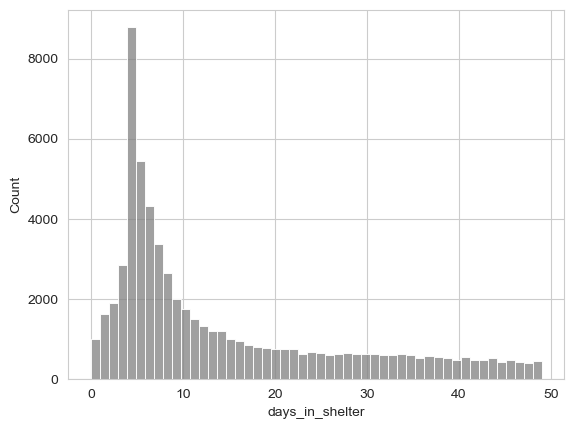

In [166]:
filtered_data = df[df.days_in_shelter < 50]# remove values that are greater than 50 to have a better visualization

plot = sns.histplot(filtered_data.days_in_shelter, color="grey", kde=False, bins=50)

plt.show()

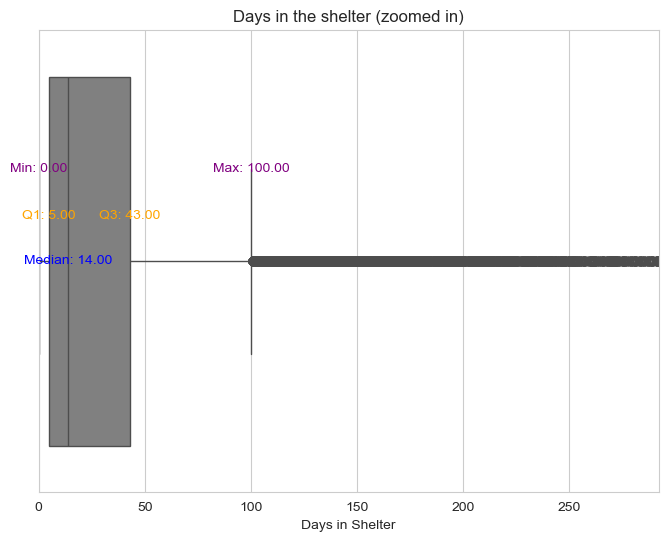

In [167]:
q1 = df['days_in_shelter'].quantile(0.25)
median = df['days_in_shelter'].median()
q3 = df['days_in_shelter'].quantile(0.75)
iqr = q3 - q1 
min_whisker = max(q1 - 1.5 * iqr, df['days_in_shelter'].min())
max_whisker = min(q3 + 1.5 * iqr, df['days_in_shelter'].max())

plt.figure(figsize=(8, 6))
ax = sns.boxplot(data=df, x='days_in_shelter', color='grey')
 
plt.xlim(df['days_in_shelter'].quantile(0.01), df['days_in_shelter'].quantile(0.99)) # Zoom in to exclude outliers

plt.text(median, 0, f'Median: {median:.2f}', ha='center', va='center', fontsize=10, color='blue')
plt.text(q1, -0.1, f'Q1: {q1:.2f}', ha='center', va='center', fontsize=10, color='orange')
plt.text(q3, -0.1, f'Q3: {q3:.2f}', ha='center', va='center', fontsize=10, color='orange')
plt.text(min_whisker, -0.2, f'Min: {min_whisker:.2f}', ha='center', va='center', fontsize=10, color='purple')
plt.text(max_whisker, -0.2, f'Max: {max_whisker:.2f}', ha='center', va='center', fontsize=10, color='purple')
 
plt.title('Days in the shelter (zoomed in)')
plt.xlabel('Days in Shelter')
 
plt.show()


Creation of df just for EDA without outliers for the rest of categories.

In [168]:
df_eda =df[df.days_in_shelter < df.days_in_shelter.quantile(0.99)]

2. Type of animal, if they are castrated or not and their sex

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_20074/1325598575.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_20074/1325598575.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_20074/1325598575.py:24: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


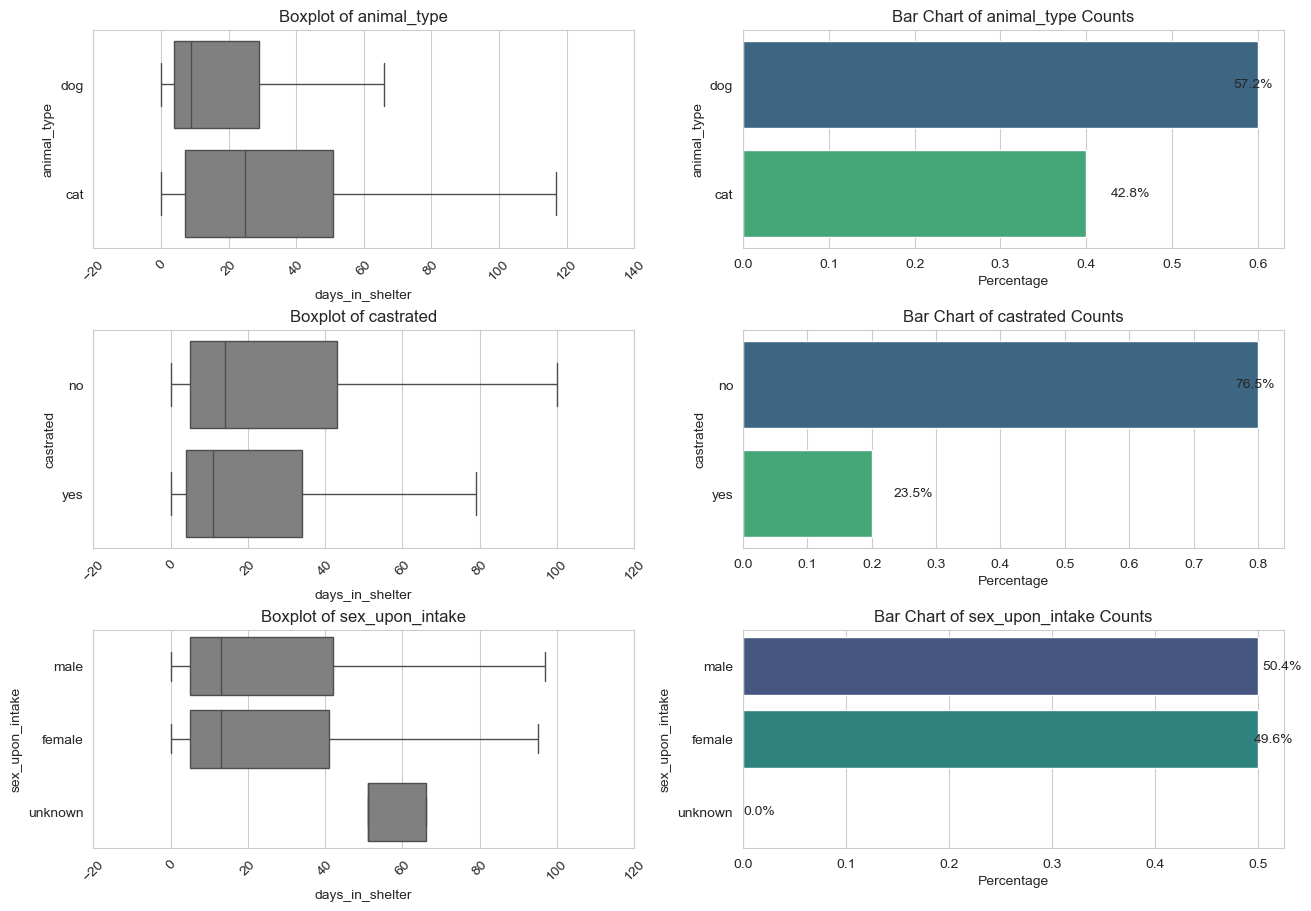

In [169]:
categories_graph = ['animal_type','castrated', 'sex_upon_intake' ]

n_cols = 2  
n_rows = len(categories_graph)  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, n_rows * 3), constrained_layout=True)

axes = axes.reshape(-1, n_cols) if len(categories_graph) > 1 else [axes]

for i, column in enumerate(categories_graph):
    value_counts = df_eda[column].value_counts(normalize=True)
    category_order = value_counts.index
    
    
    sns.boxplot(
        x="days_in_shelter", y=column, data=df_eda, 
        showfliers=False, color='grey', ax=axes[i, 0], 
        order=category_order 
        
    )
    axes[i, 0].set_xticks(axes[i, 0].get_xticks())
    axes[i, 0].tick_params(axis='x', rotation=45)  
    axes[i, 0].set_title(f'Boxplot of {column}')
    
    sns.barplot(
        x=value_counts.values.round(1), y=value_counts.index, 
        ax=axes[i, 1], palette='viridis'
    )
    axes[i, 1].set_title(f'Bar Chart of {column} Counts')

    for j, value in enumerate(value_counts.values):
        axes[i, 1].text(value, j, f'{value:.1%}', ha='left', va='center')
    axes[i, 1].set_xlabel('Percentage')
    axes[i, 1].set_ylabel(column)

plt.show()


Observations:
* Species Distribution: Dogs constitute approximately 57% of intakes, and they tend to be adopted faster compared to cats.
*  Spay/Neuter Status: Only 23% of animals are spayed or neutered upon intake, yet they appear to have shorter adoption times.
*  Gender Distribution: The intake population is nearly evenly split between males and females, with no significant difference in adoption times between genders.

Action: Remove records where sex_upon_intake is marked as unknown to ensure data quality.

3. Intake condition and type

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_20074/1453042574.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_20074/1453042574.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


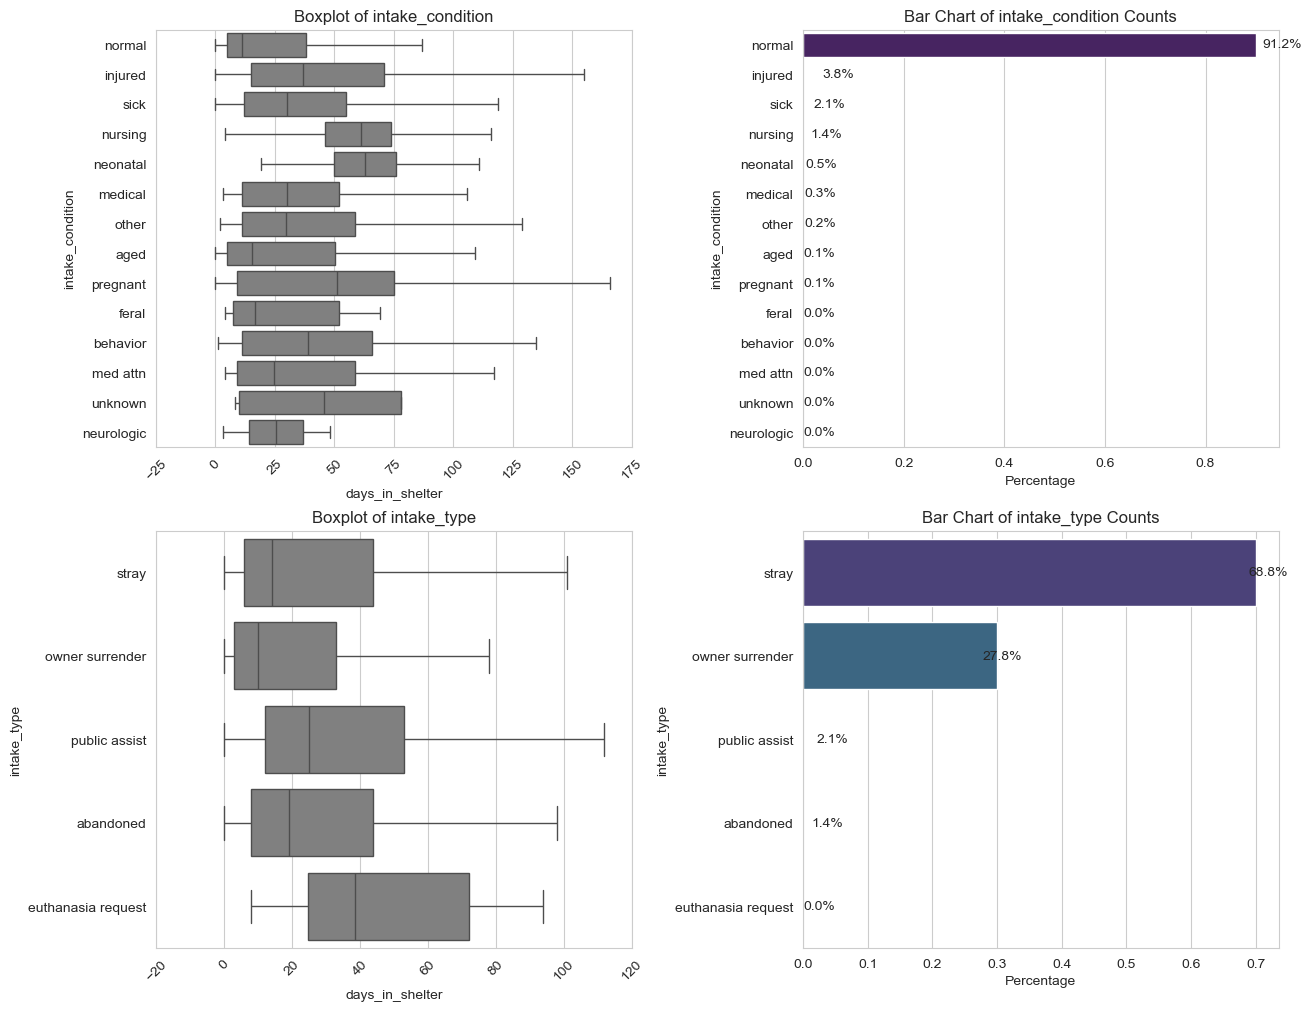

In [170]:
categories_graph = ['intake_condition',
                     'intake_type']

n_cols = 2  
n_rows = len(categories_graph)  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, n_rows * 5), constrained_layout=True)

axes = axes.reshape(-1, n_cols) if len(categories_graph) > 1 else [axes]

for i, column in enumerate(categories_graph):
    value_counts = df_eda[column].value_counts(normalize=True)
    category_order = value_counts.index  

    sns.boxplot(
        x="days_in_shelter", y=column, data=df_eda, 
        showfliers=False, color='grey', ax=axes[i, 0], 
        order=category_order 
    )
    axes[i, 0].set_xticks(axes[i, 0].get_xticks())
    axes[i, 0].tick_params(axis='x', rotation=45)  
    axes[i, 0].set_title(f'Boxplot of {column}')
    
    sns.barplot(
        x=value_counts.values.round(1), y=value_counts.index, 
        ax=axes[i, 1], palette='viridis'
    )
    axes[i, 1].set_title(f'Bar Chart of {column} Counts')
    
    for j, value in enumerate(value_counts.values):
        axes[i, 1].text(value, j, f'{value:.1%}', ha='left', va='center')
    axes[i, 1].set_xlabel('Percentage')
    axes[i, 1].set_ylabel(column)

plt.show()



Observations
* Condition at Intake: Approximately 91% of animals enter the shelter in a "normal" condition. Analyzing the adoption times across different conditions reveals that some conditions have similar patterns. These conditions can be grouped together when their adoption times are comparable, simplifying the analysis. (Actions)
    * medical:med attn and medical
    * normal
    * sick-injured
    * other.
* Intake type: 69% are stray and 28% owner surrended. these 2 groups spend the least amount of time in the shelter, as shown by the narrow range in the boxplot. Action: I will group stray, owner surrended and Other

4. hair type, if they are mix or not, miniature or not and if they are domestic.

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_20074/840254322.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_20074/840254322.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_20074/840254322.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_20074/840254322.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and w

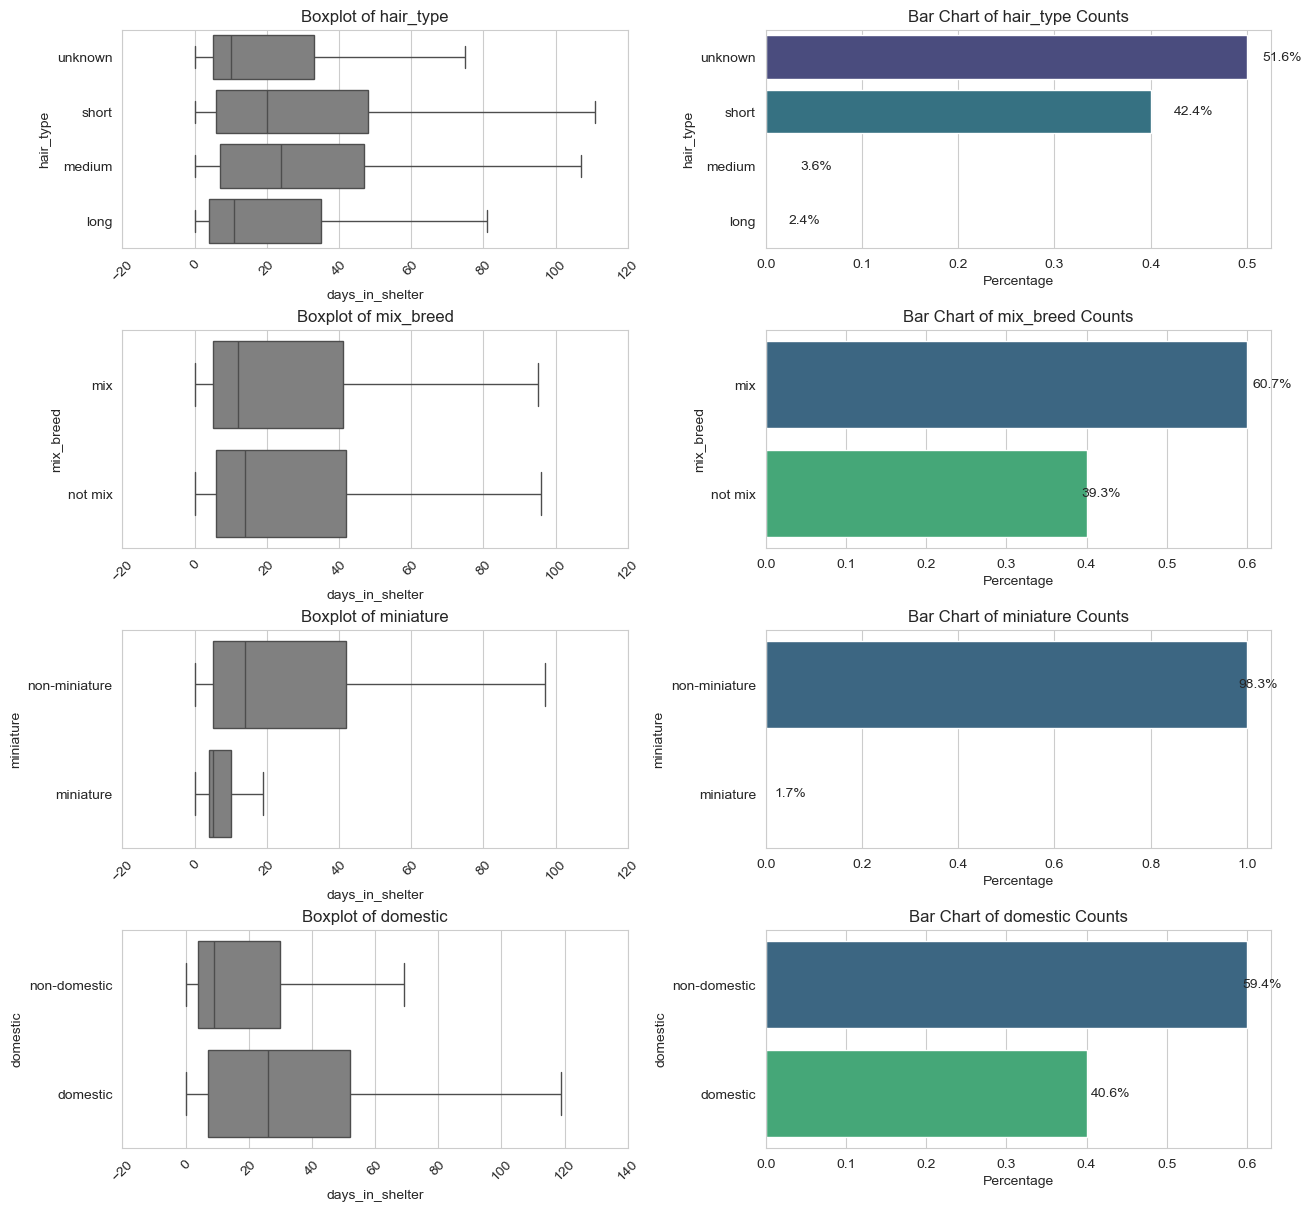

In [171]:
categories_graph = ['hair_type', 'mix_breed', 'miniature', 'domestic']

n_cols = 2  
n_rows = len(categories_graph)  
fig, axes = plt.subplots(n_rows, n_cols, figsize=(13, n_rows * 3), constrained_layout=True)

axes = axes.reshape(-1, n_cols) if len(categories_graph) > 1 else [axes]

for i, column in enumerate(categories_graph):
    value_counts = df_eda[column].value_counts(normalize=True)
    category_order = value_counts.index
    
    sns.boxplot(
        x="days_in_shelter", y=column, data=df_eda, 
        showfliers=False, color='grey', ax=axes[i, 0], 
        order=category_order  
    )
    axes[i, 0].set_xticks(axes[i, 0].get_xticks())
    axes[i, 0].tick_params(axis='x', rotation=45)  
    axes[i, 0].set_title(f'Boxplot of {column}')
    
    sns.barplot(
        x=value_counts.values.round(1), y=value_counts.index, 
        ax=axes[i, 1], palette='viridis'
    )
    axes[i, 1].set_title(f'Bar Chart of {column} Counts')
    
    
    for j, value in enumerate(value_counts.values):
        axes[i, 1].text(value, j, f'{value:.1%}', ha='left', va='center')
    axes[i, 1].set_xlabel('Percentage')
    axes[i, 1].set_ylabel(column)

plt.show()


Observations:
* Hair Type: The majority of animals have an unknown hair type (51.6%), followed by short hair (42.4%). Medium and long hair types are relatively rare (3.6% and 2.4%, respectively). Adoption Time by Hair Type: Animals with medium-short hair appear to spend slightly more time in the shelter compared to other known categories.
* Mix Breed: Mixed breeds dominate (60.7%), while purebreds ("not mix") account for 39.3%. Mix breeds appear to spend slightly less in the shelter on average compared to non-mix breeds, but the difference is not very significant.
* Miniature Animals: Non-miniature animals overwhelmingly dominate (98.3%), while miniature animals make up a very small proportion (1.7%). Miniature animals tend to be adopted much faster, with consistently shorter times in the shelter.
* Domestic vs Non-Domestic: Non-domestic animals make up 59.4% of the population, while domestic animals account for 40.6%. Domestic animals appear to have longer shelter stays on average, while non-domestic animals exhibit a wider range and longer median time.

5. color and breed

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_20074/2665314844.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_20074/2665314844.py:23: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


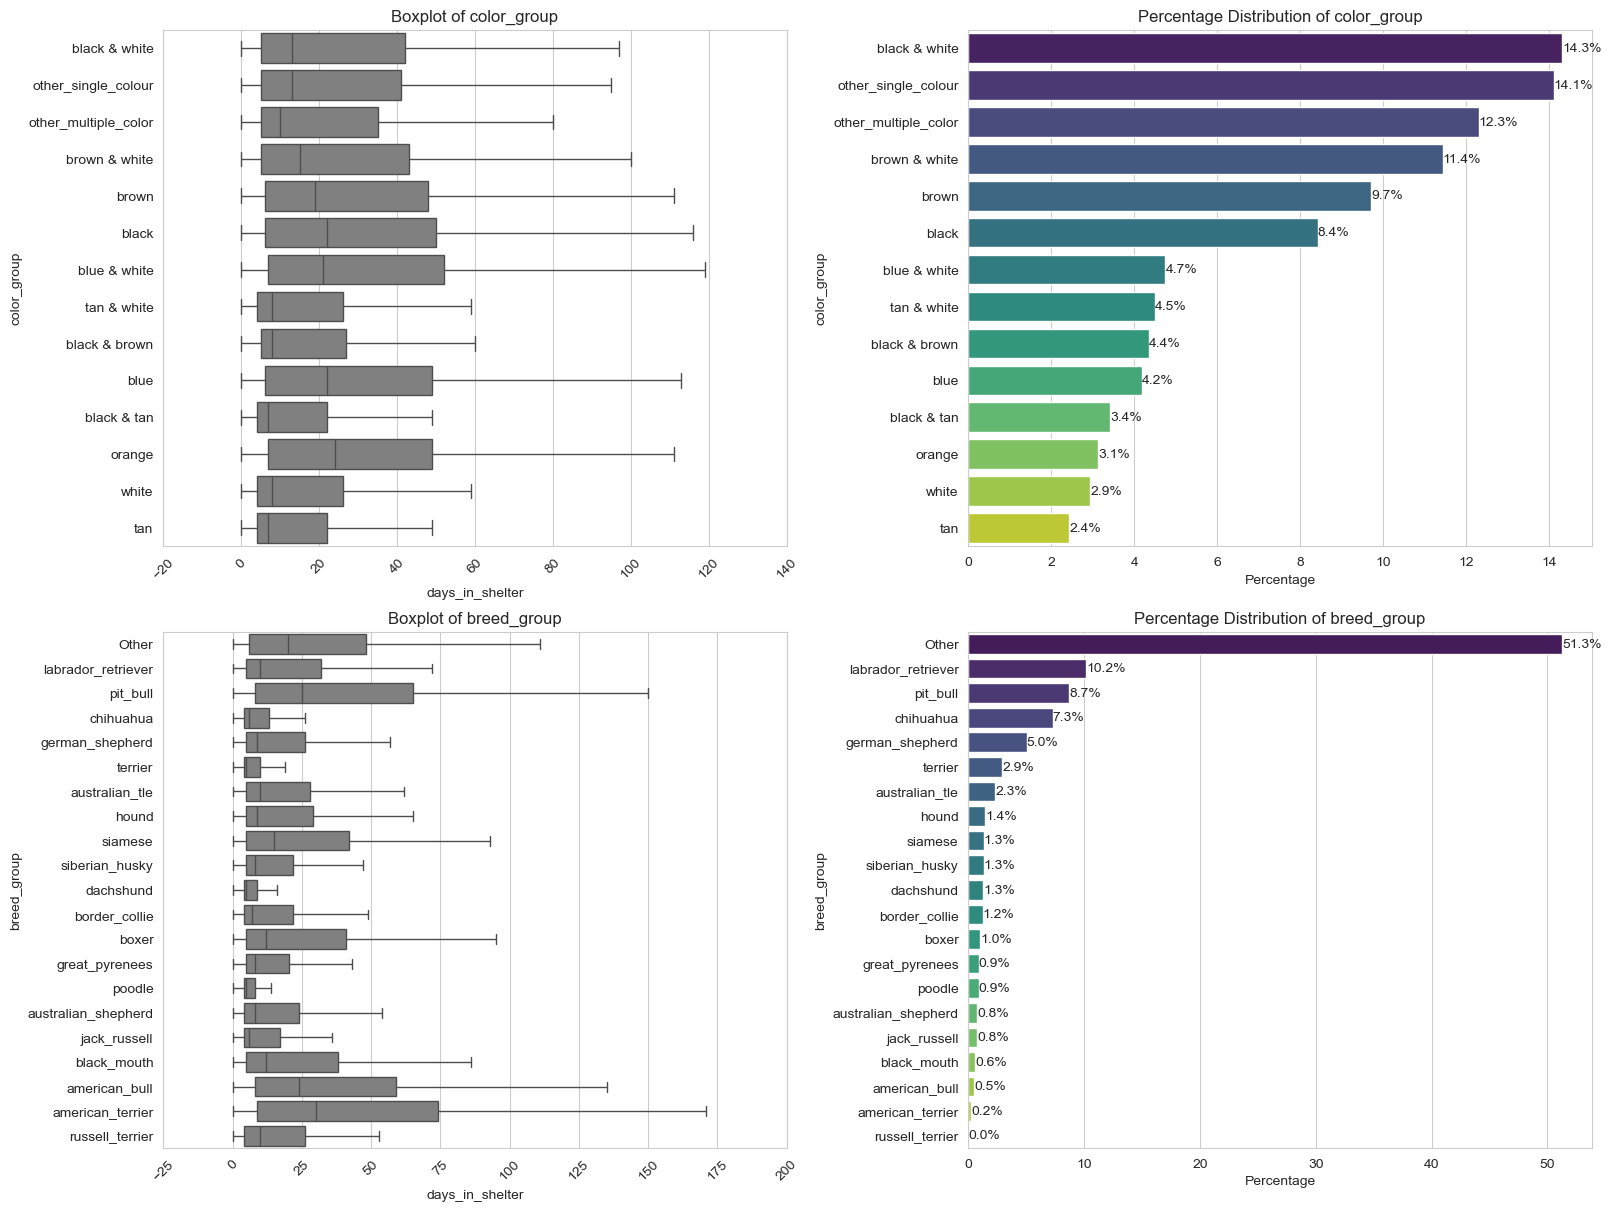

In [172]:
categories_graph = ['color_group', 'breed_group']

n_cols = 2 
n_rows = len(categories_graph) 
fig, axes = plt.subplots(n_rows, n_cols, figsize=(16, n_rows * 6), constrained_layout=True)

# Flatten axes for iteration
axes = axes.reshape(-1, n_cols) if len(categories_graph) > 1 else [axes]

for i, column in enumerate(categories_graph):
    value_counts = df_eda[column].value_counts(normalize=True) * 100 
    category_order = value_counts.index 

    sns.boxplot(
        x="days_in_shelter", y=column, data=df_eda, 
        showfliers=False, color='grey', ax=axes[i, 0], 
        order=category_order
    )
    axes[i, 0].set_xticks(axes[i, 0].get_xticks())
    axes[i, 0].tick_params(axis='x', rotation=45)
    axes[i, 0].set_title(f'Boxplot of {column}')
    
    sns.barplot(
        x=value_counts.values, y=value_counts.index, 
        ax=axes[i, 1], palette='viridis'
    )
    axes[i, 1].set_title(f'Percentage Distribution of {column}')
    axes[i, 1].set_xlabel('Percentage')
    axes[i, 1].set_ylabel(column)
    
    for j, percentage in enumerate(value_counts.values):
        axes[i, 1].text(
            percentage, j, f'{percentage:.1f}%',  
            ha='left', va='center'
        )

plt.show()


Color:   
the most common animals are black and white, accounting for 14.3% of the total, followed by brown and white at 11.4%, solid brown at 9.7%, and solid black at 8.4%.
Regarding adoption times, certain color groups such as tan and white, black and brown, black and tan, white, and tan tend to have shorter adoption times. These groups also show a smaller interquartile range (IQR), indicating less variability in their time to adoption. This suggests that these animals are adopted more consistently and efficiently compared to other color groups.

Breed:   
At first glance, we observe that breeds often labeled as "dangerous," such as Pit Bull, American Bull, and American Terrier, rusell terrier, tend to have significantly longer adoption times. Conversely, small dog breeds like Chihuahua, Terrier, Dachshund, Poodle, and Jack Russell are adopted much faster, with noticeably shorter shelter stays.

Action:Simplify the model by removing the detailed breed information and instead classify animals into two groups:
- Larger/“dangerous” breeds (e.g., Pit Bulls, American Bulls, etc.)
- Small or fast-adopting breeds (e.g., Chihuahuas, Dachshunds, etc.)
Additionally, include the most importat breeds: labrador, german sheperd, hound, siamese, sufficient for the model.

6. Age in months

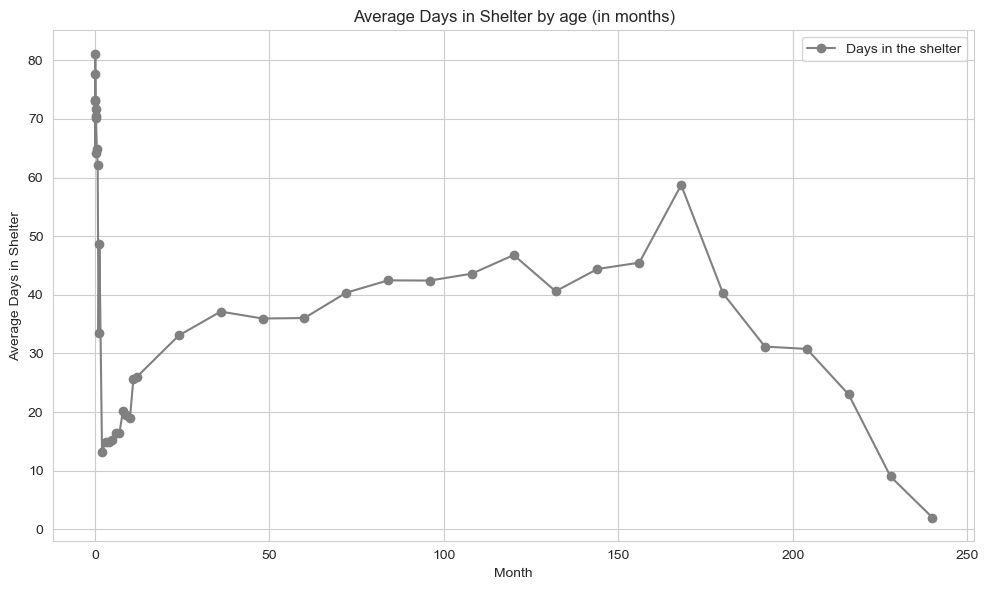

In [173]:
age_in_months = df_eda.groupby('age_in_months')['days_in_shelter'].mean().reset_index(name='avg_days_in')

plt.figure(figsize=(10, 6))
plt.plot(age_in_months['age_in_months'], age_in_months['avg_days_in'], color='grey', label='Days in the shelter', linestyle='-', marker='o') 
plt.title('Average Days in Shelter by age (in months)')
plt.xlabel('Month')
plt.ylabel('Average Days in Shelter')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()

The chart shows the average number of days animals stay in the shelter based on their age in months. 
- Young Animals (0-10 months): Newborns spend a lot of time in the shelter (close to 80 days on average), but as they grow up to around 10 months old, their adoption time drops quickly. Younger animals tend to get adopted faster.
- Middle-Aged Animals (10-150 months): Between 10 months and about 150 months (roughly 12 years old), the average time in the shelter gradually goes up, hitting a peak around the 12-year mark. This suggests middle-aged animals might take longer to find homes.
- Senior Animals (150+ months): After around 150 months, the adoption time starts dropping again. It seems very senior animals might be prioritized for adoption or other care options.

7. Time series of animales entering the shelter and being addopted

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_20074/533848525.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda['month_in'] = pd.to_datetime({
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_20074/533848525.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_eda['month_out'] = pd.to_datetime({


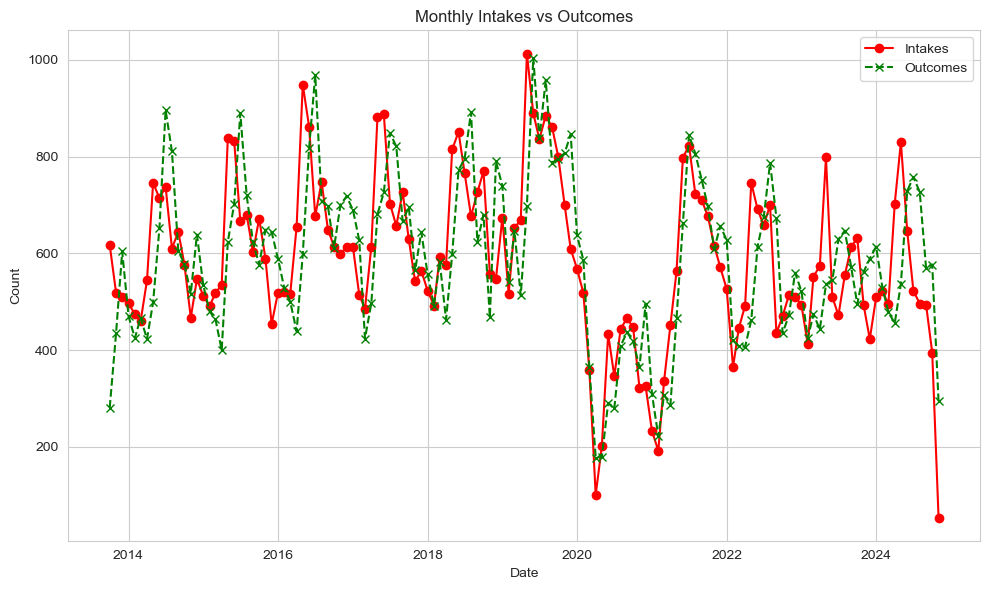

In [174]:
df_eda['month_in'] = pd.to_datetime({
    'year': df_eda['datetime_intake'].dt.year,
    'month': df_eda['datetime_intake'].dt.month,
    'day': 1
})


df_eda['month_out'] = pd.to_datetime({
    'year': df_eda['datetime_outcome'].dt.year,
    'month': df_eda['datetime_outcome'].dt.month,
    'day': 1
})

intake_data = df_eda.groupby('month_in').size().reset_index(name='count_in')
outcome_data = df_eda.groupby('month_out').size().reset_index(name='count_out')

merged_data = pd.merge(intake_data, outcome_data, 
                       left_on='month_in', 
                       right_on='month_out', 
                       how='outer').fillna(0) 

merged_data = merged_data.rename(columns={
    'month_in': 'date_in', 
    'month_out': 'date_out',
    'count_in': 'count_in',
    'count_out': 'count_out'
})

plt.figure(figsize=(10, 6))
plt.plot(merged_data['date_in'], merged_data['count_in'],color='r', label='Intakes', linestyle='-', marker='o')
plt.plot(merged_data['date_out'], merged_data['count_out'], color = 'g',label='Outcomes', linestyle='--', marker='x')

plt.title('Monthly Intakes vs Outcomes')
plt.xlabel('Date')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()

# Show the plot
plt.show()


There appears to be a seasonal pattern in intakes, with noticeable fluctuations throughout the years. Additionally, there’s a sharp drop in intakes in 2020, likely linked to the COVID-19 pandemic.

8. Monthly effect, seasonal effect in deep

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_20074/896402827.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['month_in'] = pd.to_datetime({
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_20074/896402827.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph['month_out'] = pd.to_datetime({


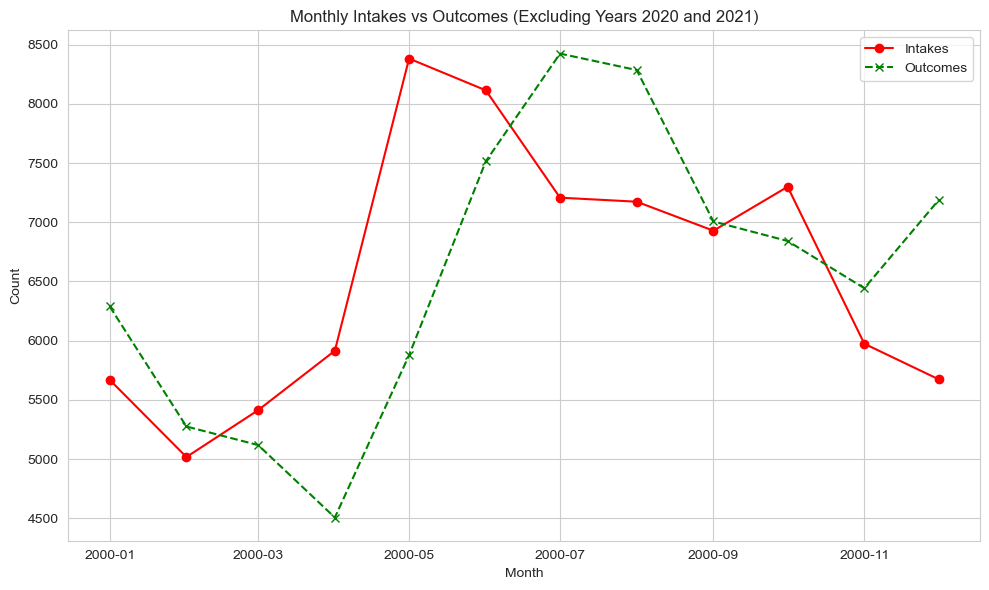

In [175]:
# Filter out years 2020 and 2021 from the DataFrame
df_graph = df_eda
[
    ~(df_eda['datetime_intake'].dt.year.isin([2020, 2021]) | 
      df_eda['datetime_outcome'].dt.year.isin([2020, 2021]))
]

df_graph['month_in'] = pd.to_datetime({
    'year': 2000,  # Arbitrary placeholder year for visualization
    'month': df_graph['datetime_intake'].dt.month,
    'day': 1
})

df_graph['month_out'] = pd.to_datetime({
    'year': 2000,  # Arbitrary placeholder year for visualization
    'month': df_graph['datetime_outcome'].dt.month,
    'day': 1
})
 
intake_data = df_graph.groupby('month_in').size().reset_index(name='count_in')
outcome_data = df_graph.groupby('month_out').size().reset_index(name='count_out')
 
merged_data = pd.merge(intake_data, outcome_data, 
                       left_on='month_in', 
                       right_on='month_out', 
                       how='outer').fillna(0)
 
merged_data = merged_data.rename(columns={
    'month_in': 'date_in', 
    'month_out': 'date_out',
    'count_in': 'count_in',
    'count_out': 'count_out'
})
 
plt.figure(figsize=(10, 6))
plt.plot(merged_data['date_in'], merged_data['count_in'], color='r', label='Intakes', linestyle='-', marker='o')
plt.plot(merged_data['date_out'], merged_data['count_out'], color='g', label='Outcomes', linestyle='--', marker='x')

plt.title('Monthly Intakes vs Outcomes (Excluding Years 2020 and 2021)')
plt.xlabel('Month')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()

There’s a clear seasonal effect where intakes peak in the middle of the year (spring/summer), while both intakes and outcomes decline toward the end of the year. 

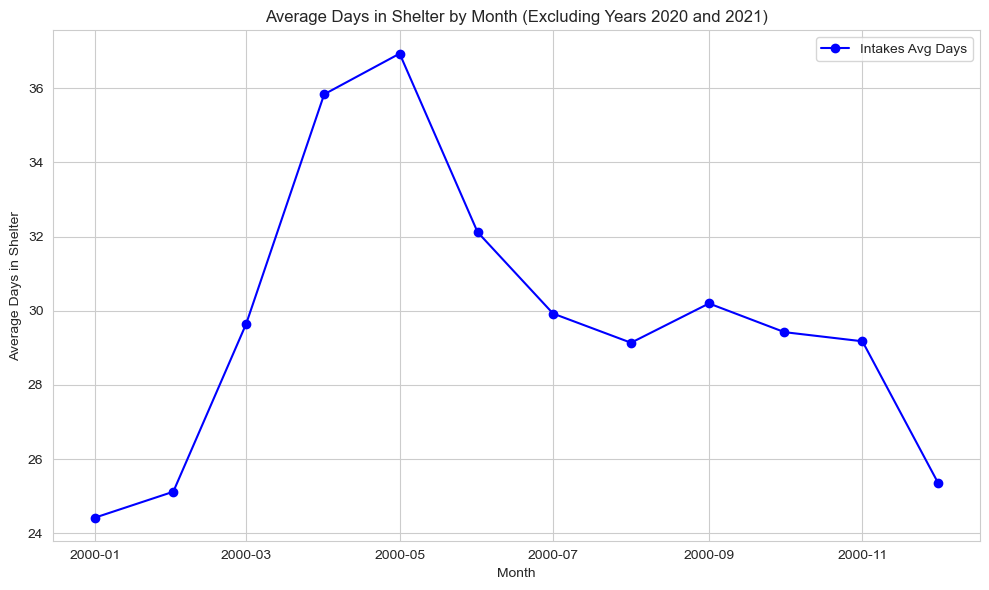

In [176]:
# Group by 'month_in' and calculate average days in shelter
intake_data = df_graph.groupby('month_in')['days_in_shelter'].mean().reset_index(name='avg_days_in')

plt.figure(figsize=(10, 6))
plt.plot(intake_data['month_in'], intake_data['avg_days_in'], color='b', label='Intakes Avg Days', linestyle='-', marker='o')

plt.title('Average Days in Shelter by Month (Excluding Years 2020 and 2021)')
plt.xlabel('Month')
plt.ylabel('Average Days in Shelter')
plt.legend()
plt.grid(True)
plt.tight_layout()

9. the day f the week when the animal entered has impact on their time in the shelter?

/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_20074/3770044732.py:7: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph_week['day_of_week_in'] = df_graph_week['datetime_intake'].dt.day_name()
/var/folders/pz/bvpq88x94b1c7g8rq2gf4j3r0000gn/T/ipykernel_20074/3770044732.py:8: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_graph_week['day_of_week_out'] = df_graph_week['datetime_outcome'].dt.day_name()


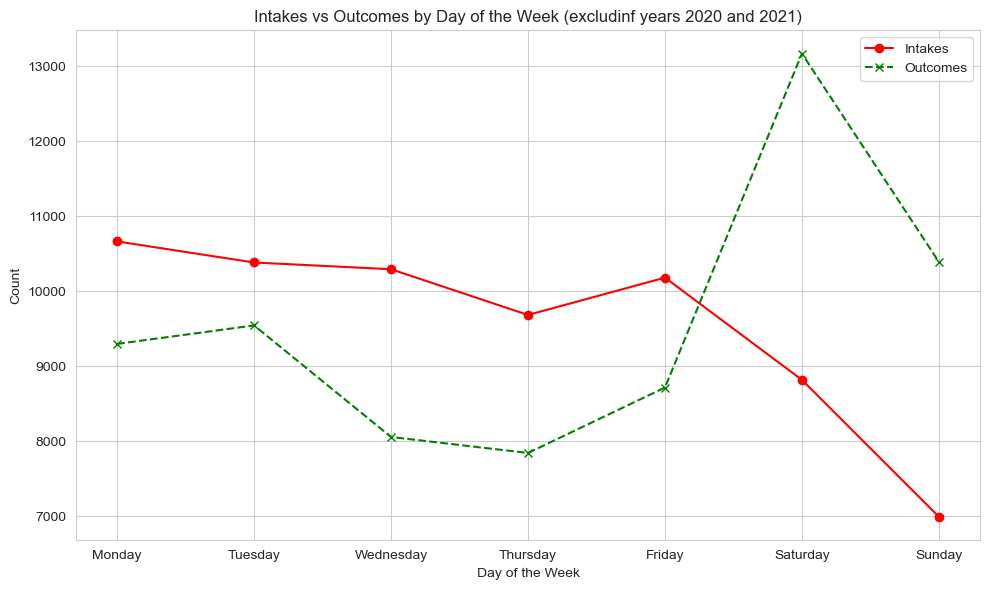

In [177]:
# Filter data for years 2020 and 2021
df_graph_week = df_eda[
   ~(df_eda['datetime_intake'].dt.year.isin([2020,2021]) | 
     df_eda['datetime_outcome'].dt.year.isin([2020,2021]))
]

df_graph_week['day_of_week_in'] = df_graph_week['datetime_intake'].dt.day_name()
df_graph_week['day_of_week_out'] = df_graph_week['datetime_outcome'].dt.day_name()

intake_data = df_graph_week.groupby('day_of_week_in').size().reset_index(name='count_in')
outcome_data = df_graph_week.groupby('day_of_week_out').size().reset_index(name='count_out')

merged_data = pd.merge(intake_data, outcome_data, 
                       left_on='day_of_week_in', 
                       right_on='day_of_week_out', 
                       how='outer').fillna(0)

merged_data = merged_data.rename(columns={
    'day_of_week_in': 'day_of_week_in',
    'day_of_week_out': 'day_of_week_out',
    'count_in': 'count_in',
    'count_out': 'count_out'
})

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
merged_data = merged_data.set_index('day_of_week_in').reindex(days_order).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(merged_data['day_of_week_in'], merged_data['count_in'], color='r', label='Intakes', linestyle='-', marker='o')
plt.plot(merged_data['day_of_week_out'], merged_data['count_out'], color='g', label='Outcomes', linestyle='--', marker='x')

plt.title('Intakes vs Outcomes by Day of the Week (excludinf years 2020 and 2021)')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


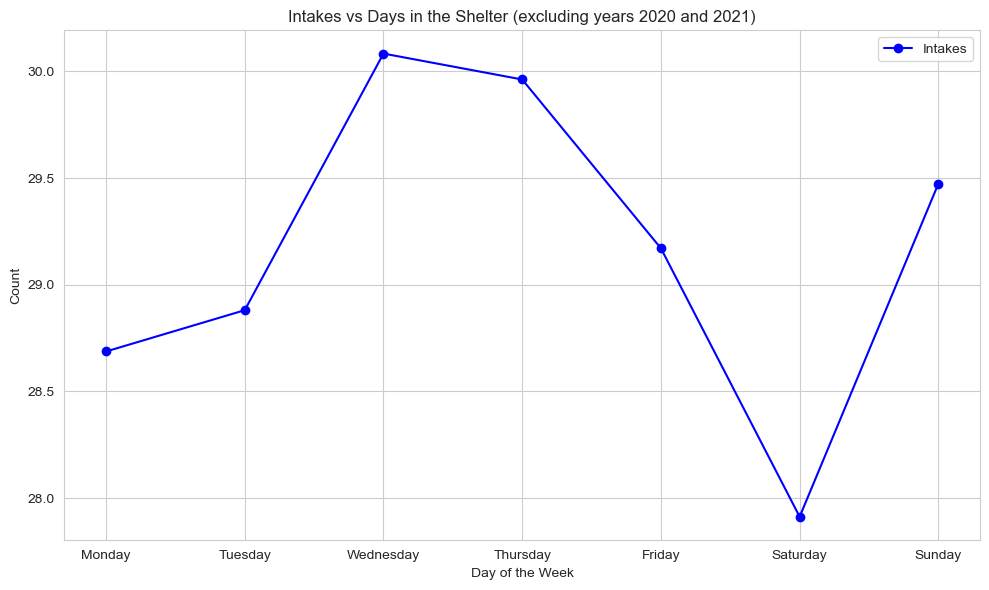

In [178]:
# Group by 'day_of_week_in' and 'day_of_week_out' to get counts
intake_data_week= df_graph_week.groupby('day_of_week_in')['days_in_shelter'].mean().reset_index(name='count_in')

days_order = ['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']
intake_data_week = intake_data_week.set_index('day_of_week_in').reindex(days_order).reset_index()

plt.figure(figsize=(10, 6))
plt.plot(intake_data_week['day_of_week_in'], intake_data_week['count_in'], color='b', label='Intakes', linestyle='-', marker='o')

plt.title('Intakes vs Days in the Shelter (excluding years 2020 and 2021)')
plt.xlabel('Day of the Week')
plt.ylabel('Count')
plt.legend()
plt.grid(True)
plt.tight_layout()

plt.show()


* Saturday is critical for outcomes: The sharp spike in outcomes suggests shelters should maximize efforts for adoptions or releases on Saturdays when public interest may be highest.
* Sunday is a low-activity day: Both intakes and outcomes drop significantly on Sundays, likely reflecting limited operational activity.  
* Wednesday-Thursday challenges: Animals brought in on Wednesdays and Thurdays tend to stay in shelters longer, indicating potential inefficiencies or lower adoption rates midweek.

10. how many animals at the same time they are?

A new metric that might be interesting is the number of animals at the same time in the shelter comparing the datetime the animal enter vs how many other animals are at the same time 

In [179]:
# # Function to calculate the overlap count for a given row
# def count_overlapping(row, df):
#     overlapping = df[
#         (df['datetime_intake'] <= row['datetime_outcome']) &  # Shelter intake is before or during this outcome
#         (df['datetime_outcome'] >= row['datetime_intake']) &  # Shelter outcome is after or during this intake
#         (df.index != row.name)  # Exclude the current record itself
#     ]
#     return len(overlapping)

# # Apply the function to each row
# df_eda['animals_in_shelter'] = df_eda.apply(lambda row: count_overlapping(row, df_eda), axis=1)


In [180]:
# plt.figure(figsize=(10, 6))
# sns.set_style('whitegrid')
# g = sns.lmplot(
#     x='days_in_shelter' , 
#     y= 'animals_in_shelter', 
#     data=df_eda,aspect=2,
#     scatter_kws={'alpha': 0.3, 'color': 'green'})
# g = (g.set_axis_labels( 'animals in the shelter', 'days in the shelter'))
# plt.title('title')
# plt.show()

The scatter plot shows a positive correlation between the number of days animals spend in the shelter and the number of animals when the animal enter in the shelter. More animals, less chances of being adopted.

In [181]:
# # Create quantile-based bins for 'days_in_shelter'
# df_eda['days_bin'] = pd.qcut(
#     df_eda['days_in_shelter'],
#     q=4, 
#     labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)'] 
# )

# # Check the binned data
# print(df_eda[['days_in_shelter', 'days_bin']].head())

# # Aggregate data: Calculate mean within each bin
# binned_data = df_eda.groupby(['days_bin', 'animal_type'], as_index=False).agg(
#     animals_in_shelter_mean=('animals_in_shelter', 'mean'),
#     days_in_shelter_mean=('days_in_shelter', 'mean')
# )

# # Plot with Seaborn lineplot
# sns.set_style('whitegrid')
# sns.set_palette('bright')

# plt.figure(figsize=(10, 6))
# sns.lineplot(
#     data=binned_data,
#     x='days_in_shelter_mean',
#     y='animals_in_shelter_mean',
#     hue='animal_type',
#     marker='o'
# )

# plt.xlabel('Days in Shelter (Mean of Quantile Bins)')
# plt.ylabel('Animals in Shelter (Mean)')
# plt.title('Animals in Shelter by Days in Quantile Bins')
# plt.legend(title='Animal Type')
# plt.show()


is the same per type of animal.

11. Animals in the shelter of the same type: adding also the match by cat-dog

In [182]:
# # Function to calculate the overlap count for a given row, considering animal_type
# def count_overlapping_by_type(row, df):
#     overlapping = df[
#         (df['datetime_intake'] <= row['datetime_outcome']) &  # Shelter intake is before or during this outcome
#         (df['datetime_outcome'] >= row['datetime_intake']) &  # Shelter outcome is after or during this intake
#         (df['animal_type'] == row['animal_type']) &           # Same animal type
#         (df.index != row.name)  # Exclude the current record itself
#     ]
#     return len(overlapping)

# # Apply the function to each row
# df_eda['animals_in_shelter_same_type'] = df_eda.apply(lambda row: count_overlapping_by_type(row, df_eda), axis=1)


In [183]:
# # Create quantile-based bins for 'days_in_shelter'
# df_eda['days_bin'] = pd.qcut(
#     df_eda['days_in_shelter'],
#     q=4, 
#     labels=['Q1 (Lowest)', 'Q2', 'Q3', 'Q4 (Highest)'] 
# )
 
# print(df_eda[['days_in_shelter', 'days_bin']].head())
 
# binned_data = df_eda.groupby(['days_bin', 'animal_type'], as_index=False).agg(
#     animals_in_shelter_same_type_mean=('animals_in_shelter_same_type', 'mean'),
#     days_in_shelter_mean=('days_in_shelter', 'mean')
# )
 
# sns.set_style('whitegrid')
# sns.set_palette('bright')

# plt.figure(figsize=(10, 6))
# sns.lineplot(
#     data=binned_data,
#     x='days_in_shelter_mean',
#     y='animals_in_shelter_same_type_mean',
#     hue='animal_type',
#     marker='o'
# )

# plt.xlabel('Days in Shelter (Mean of Quantile Bins)')
# plt.ylabel('Animals in Shelter same type (Mean)')
# plt.title('Animals in Shelter same type by Days in Quantile Bins')
# plt.legend(title='Animal Type')
# plt.show()


as there is no much change (and I also checked the model performance) I will use animals in the shelter without using from same type as takes more time to process the data - 4' vs 1'

-------

----


<h2 id="3">3. Model evaluation</h2>


<h3 id="31">3.1 Features selection pre-model</h3>


In [245]:
df.columns

Index(['animal_id', 'datetime_intake', 'found_location', 'intake_type',
       'intake_condition', 'animal_type', 'sex_upon_intake',
       'datetime_outcome', 'outcome_type', 'days_in_shelter', 'castrated',
       'age_in_months', 'hair_type', 'mix_breed', 'miniature', 'domestic',
       'breed_group', 'color_group', 'is_male', 'intake_condition_group',
       'intake_type_group', 'day_of_week_in', 'month_in',
       'animals_in_shelter_same_type', 'is_castrated', 'is_mix_breed',
       'is_dog', 'is_domestic', 'is_miniature'],
      dtype='object')

creating is_male to use instead of sex_upon_intake

In [246]:
# in sex_upon_intake column, just add if is male or not to avoid having unknown values
df['is_male'] = df['sex_upon_intake'].apply(lambda x: 1 if x =='male' else 0)
df['is_male'].value_counts()    

is_male
1    39697
0    39074
Name: count, dtype: int64

group by intake_condition

In [247]:
# condition at intake: grouping medical (med attn and medical), normal, sick_injured and rest (other)
df['intake_condition_group'] = df['intake_condition'].apply(
    lambda x: 'normal' if 'normal' in x 
    else 'sick_injured' if 'sick' in x 
    else 'sick_injured' if 'injured' in x 
    else 'medical' if 'medical' in x 
    else 'medical' if 'med attn' in x  
    else 'nursing' if 'nursing' in x 
    else 'nursing' if 'neonatal' in x 
    else 'other')

group by intake type

In [248]:
# group intake type: stray, owner surrended and Other
df['intake_type_group'] = df['intake_type'].apply(
    lambda x: 'stray' if 'stray' in x 
    else 'owner surrender' if 'owner surrender' in x 
    else 'other'
)

In [249]:
df['breed_group'].value_counts()



breed_group
Other                  40379
small_dog              10387
labrador_retriever      7998
larger_dangerous        7443
german_shepherd         3975
australian_tle          1828
hound                   1128
siamese                 1049
siberian_husky          1040
border_collie            967
boxer                    797
great_pyrenees           707
australian_shepherd      610
black_mouth              463
Name: count, dtype: int64

In [250]:
# Simplify the model by removing the detailed breed information and instead classify animals into two groups:
# - Larger/“dangerous” breeds (e.g., Pit Bulls, American Bulls, etc.)
# - Small or fast-adopting breeds (e.g., Chihuahuas, Dachshunds, etc.)
# Additionally, include the most importat breeds: labrador, german sheperd, hound, siamese, sufficient for the model.

df['breed_group'] = df['breed_group'].apply(
    lambda x: 'larger_dangerous' if 'pit' in x 
    else 'larger_dangerous' if 'bull' in x 
    else 'larger_dangerous' if 'american_terrier' in x  
    else 'small_dog' if 'chihuahua' in x 
    else 'small_dog' if 'terrier' in x 
    else 'small_dog' if 'dachshund' in x 
    else 'small_dog' if 'poodle' in x 
    else 'small_dog' if 'jack_russell' in x 
    else 'small_dog' if 'russell_terrier' in x 
    else x)  

#### Change the features with just two options to 1-0 values 

In [251]:
# is_castrated
df['is_castrated'] = df['castrated'].apply(lambda x: 1 if x =='yes' else 0)
df['is_castrated'].value_counts()

is_castrated
0    60290
1    18481
Name: count, dtype: int64

In [252]:
# is_mix_breed
df['is_mix_breed'] = df['mix_breed'].apply(lambda x: 1 if x =='mix' else 0)
df['is_mix_breed'].value_counts()

is_mix_breed
1    47780
0    30991
Name: count, dtype: int64

In [253]:
# is_miniature
df['is_miniature'] = df['miniature'].apply(lambda x: 1 if x =='miniature' else 0)
df['is_miniature'].value_counts()


is_miniature
0    77401
1     1370
Name: count, dtype: int64

In [254]:
# is_domestic
df['is_domestic'] = df['domestic'].apply(lambda x: 1 if x =='domestic' else 0)
df['is_domestic'].value_counts()


is_domestic
0    46829
1    31942
Name: count, dtype: int64

In [255]:
# is dog
df['is_dog'] = df['animal_type'].apply(lambda x: 1 if x =='dog' else 0)
df['is_dog'].value_counts()

is_dog
1    45044
0    33727
Name: count, dtype: int64

#### New features after EDA:


Day of the week the animal entered into the shelter

In [256]:
# day of the week
df['day_of_week_in'] = df['datetime_intake'].dt.day_of_week
df['day_of_week_in'].value_counts()

day_of_week_in
0    12574
1    12506
2    12361
4    12118
3    11690
5     9775
6     7747
Name: count, dtype: int64

2. Month of intake

In [257]:
# month of the year
df['month_in'] = df['datetime_intake'].dt.month
df['month_in'].value_counts()

month_in
5     8383
6     8115
10    7300
7     7208
8     7174
9     6929
11    5974
4     5915
12    5674
1     5669
3     5413
2     5017
Name: count, dtype: int64

3. Number of other animals from the same type in the shelter when the animal entered

In [374]:
# Function to calculate the overlap count for a given row, considering animal_type
def count_overlapping_by_type(row, df):
    overlapping = df[
        (df['datetime_intake'] <= row['datetime_outcome']) &  # Shelter intake is before or during this outcome
        (df['datetime_outcome'] >= row['datetime_intake']) &  # Shelter outcome is after or during this intake
       ##(df['animal_type'] == row['animal_type']) &           # Same animal type
       ## (df['breed_group'] == row['breed_group']) &        # Same day of the week
        (df.index != row.name)  # Exclude the current record itself
    ]
    return len(overlapping)

# Apply the function to each row
df['animals_in_shelter'] = df.apply(lambda row: count_overlapping_by_type(row, df_eda), axis=1)


In [375]:
df.head().T

,0,1,2,3,4
animal_id,a844350,a818975,a760053,a696408,a856107
datetime_intake,2021-10-15 11:40:00,2020-06-18 14:53:00,2017-10-11 15:46:00,2015-02-04 12:58:00,2022-04-28 11:56:00
found_location,2112 east william cannon drive in austin (tx),braker lane and metric in travis (tx),8800 south first street in austin (tx),9705 thaxton in austin (tx),4700 prock lane in austin (tx)
intake_type,stray,stray,stray,stray,stray
intake_condition,normal,normal,normal,normal,normal
animal_type,cat,cat,dog,dog,cat
sex_upon_intake,female,male,male,female,male
datetime_outcome,2021-10-20 18:51:00,2020-07-23 15:54:00,2017-10-15 18:30:00,2015-05-28 11:24:00,2022-05-02 17:54:00
outcome_type,adoption,adoption,adoption,adoption,adoption
days_in_shelter,5,35,4,112,4


In [376]:
df.columns

Index(['animal_id', 'datetime_intake', 'found_location', 'intake_type',
       'intake_condition', 'animal_type', 'sex_upon_intake',
       'datetime_outcome', 'outcome_type', 'days_in_shelter', 'castrated',
       'age_in_months', 'hair_type', 'mix_breed', 'miniature', 'domestic',
       'breed_group', 'color_group', 'is_male', 'intake_condition_group',
       'intake_type_group', 'day_of_week_in', 'month_in',
       'animals_in_shelter_same_type', 'is_castrated', 'is_mix_breed',
       'is_dog', 'is_domestic', 'is_miniature', 'animals_in_shelter'],
      dtype='object')

In [377]:
# removeoutliers from the dataset with >= 99% quantile
df = df[df['days_in_shelter'] < df['days_in_shelter'].quantile(0.99)]


In [378]:
numerical = [
    'age_in_months', 
    'month_in', 
    'animals_in_shelter',
    'day_of_week_in',
    'is_dog',
    'is_mix_breed', 
    'is_miniature', 
    'is_domestic'] 
  
categorical = [    
    'intake_type_group',
    'intake_condition_group',  
    'is_male',
    'castrated',
    'hair_type',
   # 'day_of_week_in',
     'breed_group',     
     'color_group'
]
#   

In [379]:
# checckiing for missing values in columns inside numerical or categorical
missing_numerical = df[numerical].isnull().sum()
missing_categorical = df[categorical].isnull().sum()

print(f"Missing values in numerical columns:\n{missing_numerical[missing_numerical > 0]}\n")
print(f"Missing values in categorical columns:\n{missing_categorical[missing_categorical > 0]}")


Missing values in numerical columns:
Series([], dtype: int64)

Missing values in categorical columns:
Series([], dtype: int64)


------

<h3 id="32">3.2 Training models</h3>


For training the model we will use the whole dataset except the last 20% of the records ordered by datetime_intake that would be the test

Preparing the training dataset, validation and test dataset.

In [434]:
# for test: last 20% of the records based on the datetime_intake column
df.reset_index(drop=True, inplace=True)
df_test = df.sort_values('datetime_intake').tail(int(len(df) * 0.2))
print('test df from: ',df_test['datetime_intake'].min(), 'test df to: ' ,df_test['datetime_intake'].max())

# for train: the rest of the records that I will divide into train and validation sets
df_full_train = df.drop(df_test.index).reset_index(drop=True)
df_train, df_val = train_test_split(df_full_train, test_size=0.20, random_state=1)

df_full_train = df_full_train.reset_index(drop=True)
df_train = df_train.reset_index(drop=True)
df_val = df_val.reset_index(drop=True)
df_test = df_test.reset_index(drop=True)

y_full_train = df_full_train.days_in_shelter.values
y_train = df_train.days_in_shelter.values
y_val = df_val.days_in_shelter.values
y_test = df_test.days_in_shelter.values

del df_full_train['days_in_shelter']
del df_train['days_in_shelter']
del df_val['days_in_shelter']
del df_test['days_in_shelter']

test df from:  2022-06-20 16:32:00 test df to:  2024-11-10 13:10:00


In [435]:
dv = DictVectorizer(sparse=False)

train_dict = df_train[categorical + numerical].to_dict(orient='records')
X_train = dv.fit_transform(train_dict)

In [436]:
val_dict = df_val[categorical + numerical].to_dict(orient='records')
X_val = dv.transform(val_dict)  # Use transform, not fit_transform

In [425]:
full_train_dict = df_full_train[categorical + numerical].to_dict(orient='records')
X_full_train = dv.transform(full_train_dict)


In [426]:
test_dict = df_test[categorical + numerical].to_dict(orient='records')
X_test = dv.transform(test_dict)

In [383]:
print(dv.feature_names_)

['age_in_months', 'animals_in_shelter', 'breed_group=Other', 'breed_group=australian_shepherd', 'breed_group=australian_tle', 'breed_group=black_mouth', 'breed_group=border_collie', 'breed_group=boxer', 'breed_group=german_shepherd', 'breed_group=great_pyrenees', 'breed_group=hound', 'breed_group=labrador_retriever', 'breed_group=larger_dangerous', 'breed_group=siamese', 'breed_group=siberian_husky', 'breed_group=small_dog', 'castrated=no', 'castrated=yes', 'color_group=black', 'color_group=black & brown', 'color_group=black & tan', 'color_group=black & white', 'color_group=blue', 'color_group=blue & white', 'color_group=brown', 'color_group=brown & white', 'color_group=orange', 'color_group=other_multiple_color', 'color_group=other_single_colour', 'color_group=tan', 'color_group=tan & white', 'color_group=white', 'day_of_week_in', 'hair_type=long', 'hair_type=medium', 'hair_type=short', 'hair_type=unknown', 'intake_condition_group=medical', 'intake_condition_group=normal', 'intake_con

-------

<h4 id="33">3.2.1 Linear regression</h4>

In [384]:
lr_model = LinearRegression()

lr_model.fit(X_train, y_train)
y_val_pred = lr_model.predict(X_val)

mae = mean_absolute_error(y_val, y_val_pred)
mse = mean_squared_error(y_val, y_val_pred)
r2 = r2_score(y_val, y_val_pred)

print(f"Mean Absolute Error (MAE): {mae:.2f}")
print(f"RMSE: {np.sqrt(mse):.2f}")
print(f"Mean Squared Error (MSE): {mse:.2f}")
print(f"R² Score: {r2:.2f}")

Mean Absolute Error (MAE): 8.38
RMSE: 11.63
Mean Squared Error (MSE): 135.31
R² Score: 0.79


In [385]:
feature_importance = pd.DataFrame({
    'Feature': dv.feature_names_,
    'Coefficient': lr_model.coef_ 
}).sort_values(by='Coefficient', ascending=False)
 
feature_importance['Coefficient'] = feature_importance['Coefficient'].round(3)
print('positive top10 features: ',feature_importance.head(10))
print('negative top10 features: ',feature_importance.tail(10))


positive top10 features:                                  Feature  Coefficient
39       intake_condition_group=nursing        3.472
12         breed_group=larger_dangerous        3.177
37       intake_condition_group=medical        3.046
42              intake_type_group=other        2.595
4            breed_group=australian_tle        1.129
7                     breed_group=boxer        1.063
41  intake_condition_group=sick_injured        0.919
11       breed_group=labrador_retriever        0.907
35                      hair_type=short        0.635
18                    color_group=black        0.485
negative top10 features:                                Feature  Coefficient
9          breed_group=great_pyrenees       -0.973
13                breed_group=siamese       -0.997
45                             is_dog       -1.021
14         breed_group=siberian_husky       -1.024
6           breed_group=border_collie       -1.084
43  intake_type_group=owner surrender       -1.093
44      

cross-validation 

In [386]:
from sklearn.model_selection import cross_val_score
 
scores = cross_val_score(LinearRegression(), X_train, y_train, scoring='neg_mean_squared_error', cv=5) 

rmse_scores = (-scores)**0.5
 
rmse_mean = np.mean(rmse_scores)
rmse_std = np.std(rmse_scores)
 
sem = rmse_std / np.sqrt(len(rmse_scores))

# 95% confidence interval
z = 1.96  
lower_bound = rmse_mean - z * sem
upper_bound = rmse_mean + z * sem

# Print results
print(f"Cross-Validated RMSE: {rmse_mean:.2f}")
print(f"95% Confidence Interval: [{lower_bound:.2f}, {upper_bound:.2f}]")


Cross-Validated RMSE: 11.61
95% Confidence Interval: [11.53, 11.68]


------

<h4 id="322">3.2.2 Random Forest</h4>

In [387]:
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import root_mean_squared_error

rf = RandomForestRegressor(n_estimators=10, random_state=1, n_jobs=-1)
rf.fit(X_train, y_train)

RandomForestRegressor(n_estimators=10, n_jobs=-1, random_state=1)

In [388]:
y_pred = rf.predict(X_val)
root_mean_squared_error(y_val, y_pred)

8.316678164750014

In [389]:
%matplotlib inline

In [390]:
from tqdm.auto import tqdm
from sklearn.metrics import mean_squared_error

In [391]:
scores = []

rf = RandomForestRegressor(
    n_estimators=1,
    random_state=1,
    n_jobs=-1,
    warm_start=True,
)

for n in tqdm(range(10, 201, 10)):
    rf.n_estimators = n
    rf.fit(X_train, y_train)
    
    y_pred = rf.predict(X_val)
    score = np.sqrt(mean_squared_error(y_val, y_pred))
    
    scores.append((n, score))

df_scores = pd.DataFrame(scores, columns=['n_estimators', 'rmse'])

  0%|          | 0/20 [00:00<?, ?it/s]

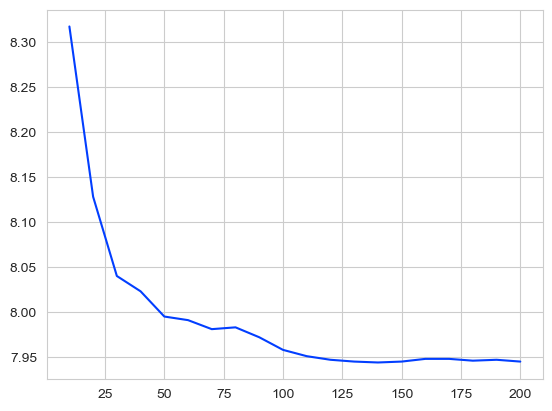

In [392]:
#plt.plot(df_scores.n_estimators, df_scores.rmse)
plt.plot(df_scores.n_estimators, df_scores.rmse.round(3))

plt.show()

In [393]:
scores = []

for d in tqdm([10, 15, 20, 25, 35,40, 45, 55]):
    rf = RandomForestRegressor(
        n_estimators=0,
        max_depth=d,
        random_state=1,
        n_jobs=-1,
        warm_start=True
    )

    for n in tqdm(range(10, 201, 10)):
        rf.n_estimators = n
        rf.fit(X_train, y_train)

        y_pred = rf.predict(X_val)
        score = np.sqrt(mean_squared_error(y_val, y_pred))

        scores.append((d, n, score))

columns = ['max_depth', 'n_estimators', 'rmse']
df_scores = pd.DataFrame(scores, columns=columns)

  0%|          | 0/8 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

  0%|          | 0/20 [00:00<?, ?it/s]

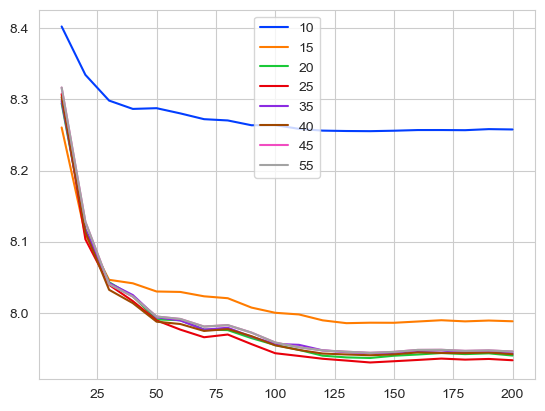

In [394]:
for d in [10, 15, 20, 25, 35, 40,45, 55]:
    df_subset = df_scores[df_scores.max_depth == d]
    plt.plot(df_subset.n_estimators, df_subset.rmse, label=d)

plt.legend()
plt.show()

In [419]:
rf = RandomForestRegressor(
    n_estimators=125,
    max_depth=25,
    random_state=1,
    n_jobs=-1
)
rf.fit(X_train, y_train)

RandomForestRegressor(max_depth=25, n_estimators=200, n_jobs=-1, random_state=1)

In [420]:
y_pred = rf.predict(X_val)
root_mean_squared_error(y_val, y_pred)

7.933214255468292

In [416]:
df_importances = pd.DataFrame()
df_importances['feature'] = dv.feature_names_
df_importances['importance'] = rf.feature_importances_
df_importances.sort_values(by='importance', ascending=False).head(20)

,feature,importance
1,animals_in_shelter,0.832543
50,month_in,0.079921
0,age_in_months,0.021731
32,day_of_week_in,0.010036
49,is_mix_breed,0.007096
47,is_male,0.002430
43,intake_type_group=owner surrender,0.002171
38,intake_condition_group=normal,0.002089
25,color_group=brown & white,0.002014
21,color_group=black & white,0.001924


doing once the grid search to verify our results before

In [418]:
# # using grid search to find the best hyperparameters
# from sklearn.model_selection import GridSearchCV

# param_grid = {
#     'n_estimators': [75, 100, 125, 150, 200],
#     'max_depth': [10, 15, 20, 25, 35,40, 45, 55],
# }

# rf = RandomForestRegressor(random_state=1, n_jobs=-1)

# grid_search = GridSearchCV(rf, param_grid, cv=5, scoring='neg_mean_squared_error', n_jobs=-1)
# grid_search.fit(X_train, y_train)

# print(f"Best parameters: {grid_search.best_params_}")

/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/joblib/externals/loky/process_executor.py:752: UserWarning: A worker stopped while some jobs were given to the executor. This can be caused by a too short worker timeout or by a memory leak.
  warnings.warn(


Best parameters: {'max_depth': 25, 'n_estimators': 200}


In [431]:
# using the full train set to train the model and then evaluate it on the test set
rf = RandomForestRegressor(
    n_estimators=125,
    max_depth=25,
    random_state=1,
    n_jobs=-1
)

rf.fit(X_full_train, y_full_train)
y_test_pred = rf.predict(X_test)
rmse = root_mean_squared_error(y_test, y_test_pred)
print(f"Test RMSE: {rmse:.2f}")


Test RMSE: 9.79


---

#### XGboost

In [432]:
import io
from contextlib import redirect_stdout
import xgboost as xgb
 
features = list(dv.get_feature_names_out()) 

dtrain = xgb.DMatrix(X_train, label=y_train, feature_names=features)
dval = xgb.DMatrix(X_val, label=y_val, feature_names=features)

# Watchlist for monitoring training and validation
watchlist = [(dtrain, 'train'), (dval, 'val')]



In [399]:
# XGBoost parameters for regression
xgb_params = {
    'eta': 0.03,                 # Learning rate: default 0.3
    'max_depth': 6,              # Maximum depth of trees: default 6
    'min_child_weight': 1,       # Minimum weight sum of child nodes
    'objective': 'reg:squarederror',  # Regression objective
    'nthread': -1,                # Number of threads
    'seed': 1,                   # Random seed
    'verbosity': 1,              # to display warnings
    'eval_metric': 'rmse'        # Metric for monitoring performance
}



rmse by boosting rounds

In [433]:
# Redirect stdout to capture output
f = io.StringIO()
with redirect_stdout(f):
    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=200,    
        verbose_eval=5,       
        evals=watchlist           
    )

captured_output = f.getvalue()
print("Captured Output:\n")
print(captured_output)

y_pred = model.predict(dval)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Root Mean Squared Error: {rmse}")

evals_result = {}

# Train again to capture results for plotting
model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=200,
    evals=watchlist,
    verbose_eval=5,
    evals_result=evals_result
)

Captured Output:

[0]	train-rmse:25.36274	val-rmse:25.33329
[5]	train-rmse:18.99844	val-rmse:19.01663
[10]	train-rmse:15.19159	val-rmse:15.23487
[15]	train-rmse:12.64189	val-rmse:12.72424
[20]	train-rmse:11.48247	val-rmse:11.60109
[25]	train-rmse:10.25940	val-rmse:10.42555
[30]	train-rmse:9.58812	val-rmse:9.78768
[35]	train-rmse:9.08741	val-rmse:9.31454
[40]	train-rmse:8.75467	val-rmse:9.00734
[45]	train-rmse:8.54611	val-rmse:8.82139
[50]	train-rmse:8.39602	val-rmse:8.68379
[55]	train-rmse:8.25675	val-rmse:8.55799
[60]	train-rmse:8.20188	val-rmse:8.51046
[65]	train-rmse:8.15518	val-rmse:8.47168
[70]	train-rmse:8.08943	val-rmse:8.41738
[75]	train-rmse:8.03189	val-rmse:8.36729
[80]	train-rmse:7.98541	val-rmse:8.32591
[85]	train-rmse:7.96082	val-rmse:8.30973
[90]	train-rmse:7.93023	val-rmse:8.29131
[95]	train-rmse:7.90182	val-rmse:8.27264
[100]	train-rmse:7.88625	val-rmse:8.26230
[105]	train-rmse:7.87028	val-rmse:8.25233
[110]	train-rmse:7.85218	val-rmse:8.24222
[115]	train-rmse:7.83286	v

/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


[50]	train-rmse:8.39602	val-rmse:8.68379
[55]	train-rmse:8.25675	val-rmse:8.55799
[60]	train-rmse:8.20188	val-rmse:8.51046
[65]	train-rmse:8.15518	val-rmse:8.47168
[70]	train-rmse:8.08943	val-rmse:8.41738
[75]	train-rmse:8.03189	val-rmse:8.36729
[80]	train-rmse:7.98541	val-rmse:8.32591
[85]	train-rmse:7.96082	val-rmse:8.30973
[90]	train-rmse:7.93023	val-rmse:8.29131
[95]	train-rmse:7.90182	val-rmse:8.27264
[100]	train-rmse:7.88625	val-rmse:8.26230
[105]	train-rmse:7.87028	val-rmse:8.25233
[110]	train-rmse:7.85218	val-rmse:8.24222
[115]	train-rmse:7.83286	val-rmse:8.23079
[120]	train-rmse:7.81873	val-rmse:8.22374
[125]	train-rmse:7.80833	val-rmse:8.22107
[130]	train-rmse:7.79476	val-rmse:8.21416
[135]	train-rmse:7.77905	val-rmse:8.20718
[140]	train-rmse:7.76616	val-rmse:8.20190
[145]	train-rmse:7.75629	val-rmse:8.19945
[150]	train-rmse:7.74357	val-rmse:8.19388
[155]	train-rmse:7.73396	val-rmse:8.19211
[160]	train-rmse:7.72530	val-rmse:8.18763
[165]	train-rmse:7.71179	val-rmse:8.18357
[1

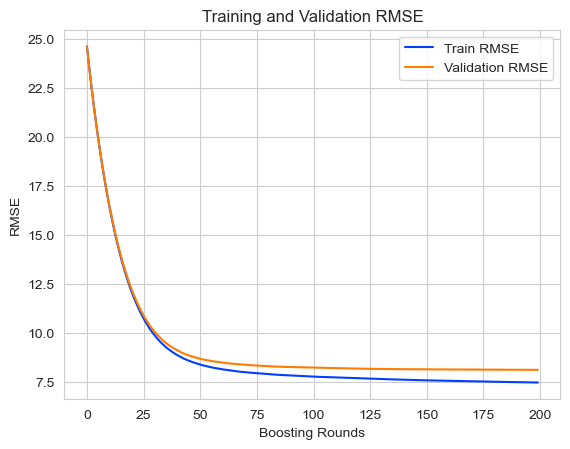

In [401]:
train_rmse = evals_result['train']['rmse']
val_rmse = evals_result['val']['rmse']

plt.plot(train_rmse, label='Train RMSE')
plt.plot(val_rmse, label='Validation RMSE')
plt.xlabel('Boosting Rounds')
plt.ylabel('RMSE')
plt.title('Training and Validation RMSE')
plt.legend()
plt.show()


- Both the training and validation RMSE values drop steeply in the first 20–30 boosting rounds. This indicates that the model is quickly learning the main patterns in the data during the early stages of training.  
- After around 50–100 boosting rounds, the RMSE for both training and validation stabilizes, showing diminishing returns for additional rounds. This indicates the model has reached a near-optimal level of performance.  
- The training and validation RMSE curves are very close to each other throughout the boosting process -> The model is not overfitting significantly. I will use the regularization parameters (alpha, or eta) and early stopping as they are useful to prevent overfitting.

In [402]:
model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=200,  # Maximum boosting rounds
    evals=watchlist,
    verbose_eval=5,
    early_stopping_rounds=5 # Stop if no improvement for 10 rounds
) 

[0]	train-rmse:24.59843	val-rmse:24.57309
[5]	train-rmse:19.88583	val-rmse:19.89875
[10]	train-rmse:16.38769	val-rmse:16.44116
[15]	train-rmse:13.83705	val-rmse:13.92606
[20]	train-rmse:12.01588	val-rmse:12.13491
[25]	train-rmse:10.73882	val-rmse:10.89117
[30]	train-rmse:9.86119	val-rmse:10.04577
[35]	train-rmse:9.26442	val-rmse:9.47715
[40]	train-rmse:8.86454	val-rmse:9.10991
[45]	train-rmse:8.58610	val-rmse:8.85840
[50]	train-rmse:8.39108	val-rmse:8.68606
[55]	train-rmse:8.24689	val-rmse:8.56752
[60]	train-rmse:8.14537	val-rmse:8.48948
[65]	train-rmse:8.06102	val-rmse:8.42498
[70]	train-rmse:7.99941	val-rmse:8.37841
[75]	train-rmse:7.94602	val-rmse:8.33881
[80]	train-rmse:7.90116	val-rmse:8.30587
[85]	train-rmse:7.86450	val-rmse:8.28003
[90]	train-rmse:7.83274	val-rmse:8.26479
[95]	train-rmse:7.80172	val-rmse:8.25057
[100]	train-rmse:7.77752	val-rmse:8.23582
[105]	train-rmse:7.75427	val-rmse:8.22230
[110]	train-rmse:7.73586	val-rmse:8.21104
[115]	train-rmse:7.71447	val-rmse:8.19816
[

In [437]:
y_pred = model.predict(dval)
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Validation RMSE: {rmse}")

Validation RMSE: 8.159561806716354


/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


Hyperparameter tunning

ETA

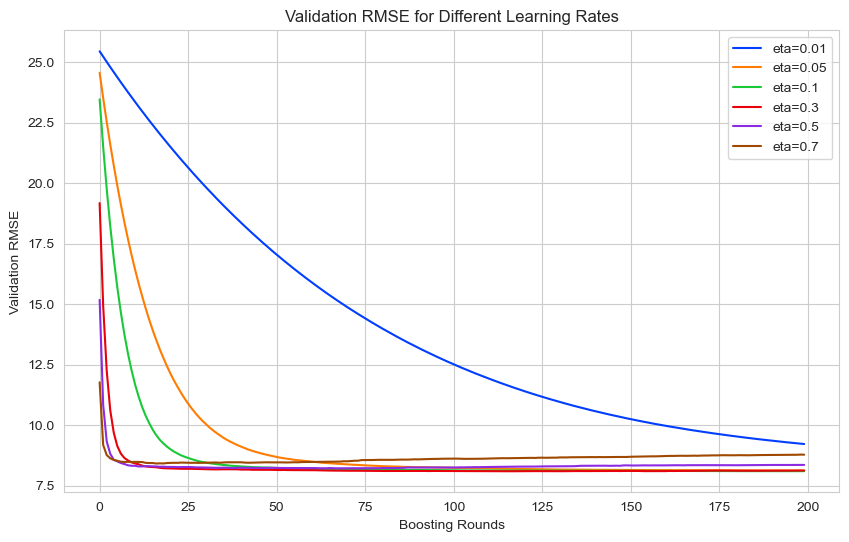

Final RMSE for eta=0.01: 9.221774409384699
Final RMSE for eta=0.05: 8.124160042908256
Final RMSE for eta=0.1: 8.099205352928717
Final RMSE for eta=0.3: 8.125733066117583
Final RMSE for eta=0.5: 8.358187468674831
Final RMSE for eta=0.7: 8.780524941950413


In [439]:

def train_xgboost(eta, num_boost_round, early_stopping_rounds=None):
    xgb_params = {
        'eta': eta,                
        'max_depth': 6,             
        'min_child_weight': 1,       
        'objective': 'reg:squarederror',  
        'nthread': -1,                 
        'seed': 1,                
        'verbosity': 1,              
        'eval_metric': 'rmse'        
    }

    evals_result = {}

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        verbose_eval=False,
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result
    )
    
    return evals_result, model
 
results = {}
for eta in [0.01,0.05,0.1, 0.3, 0.5, 0.7]:
    evals_result, model = train_xgboost(eta=eta, num_boost_round=200)
    results[eta] = evals_result


plt.figure(figsize=(10, 6))

for eta, evals_result in results.items():
    val_rmse = evals_result['val']['rmse']
    plt.plot(range(len(val_rmse)), val_rmse, label=f'eta={eta}')

plt.xlabel('Boosting Rounds')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE for Different Learning Rates')
plt.legend()
plt.show()


for eta, evals_result in results.items():
    print(f"Final RMSE for eta={eta}: {evals_result['val']['rmse'][-1]}")


This chart shows the validation RMSE for different learning rates (eta) over boosting rounds in XGBoost. Here's what you can infer from this plot:

The green (eta = 0.1) and red (eta = 0.3) lines reach low RMSE values quickly and stabilize effectively.
These learning rates strike a good balance between speed of convergence and generalization, making them ideal in many cases.

The orange (eta = 0.7) and purple (eta = 0.5) lines converge very quickly in the first 10–25 boosting rounds.
However, after rapid convergence, the RMSE plateaus and doesn’t improve much. This indicates that high learning rates lead to fast learning but may fail to fully optimize the model.
The risk of overfitting or poor generalization increases with higher eta.

Lower eta (e.g., 0.01) achieves a slightly lower RMSE over time but takes significantly longer (many boosting rounds).


max_depth

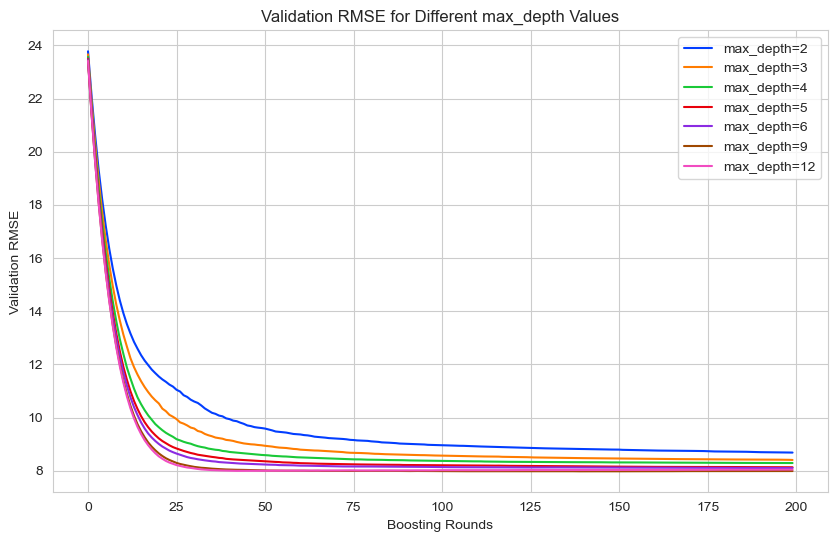

Final RMSE for max_depth=2: 8.68069645670558
Final RMSE for max_depth=3: 8.402844476263285
Final RMSE for max_depth=4: 8.287749101363104
Final RMSE for max_depth=5: 8.128633171992517
Final RMSE for max_depth=6: 8.099205352928717
Final RMSE for max_depth=9: 7.986525541211415
Final RMSE for max_depth=12: 8.041430513748814


In [440]:
# Define a function to train models with varying max_depth
def train_xgboost_with_max_depth(max_depth, num_boost_round, eta=0.1, early_stopping_rounds=None):
    xgb_params = {
        'eta': eta,              
        'max_depth': max_depth,      
        'min_child_weight': 1,       
        'objective': 'reg:squarederror',         
         'nthread': -1,              
        'seed': 1,                   
        'verbosity': 1,             
        'eval_metric': 'rmse'}
                        

    evals_result = {}

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        verbose_eval=False,  
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result
    )
    
    return evals_result, model


max_depth_values = [2, 3, 4,5, 6, 9, 12]
results = {}

for max_depth in max_depth_values:
    evals_result, model = train_xgboost_with_max_depth(max_depth=max_depth, num_boost_round=200)
    results[max_depth] = evals_result


plt.figure(figsize=(10, 6))

for max_depth, evals_result in results.items():
    val_rmse = evals_result['val']['rmse']
    plt.plot(range(len(val_rmse)), val_rmse, label=f'max_depth={max_depth}')

plt.xlabel('Boosting Rounds')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE for Different max_depth Values')
plt.legend()
plt.show()


for max_depth, evals_result in results.items():
    print(f"Final RMSE for max_depth={max_depth}: {evals_result['val']['rmse'][-1]}")


Choose max_depth=6 as is a good balance between performance and computational efficiency. 
Values like max_depth=9 or 12 add complexity without significant performance gains and may lead to overfitting

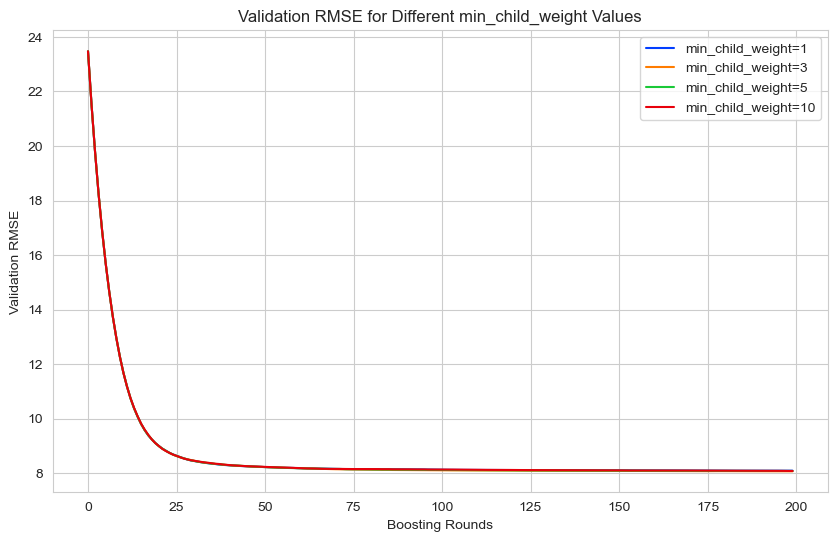

Final RMSE for min_child_weight=1: 8.099205352928717
Final RMSE for min_child_weight=3: 8.077346964432435
Final RMSE for min_child_weight=5: 8.089371404959731
Final RMSE for min_child_weight=10: 8.088941233806485


In [442]:
# Define a function to train models with varying min_child_weight
def train_xgboost_with_min_child_weight(min_child_weight, num_boost_round, eta=0.1, max_depth=6, early_stopping_rounds=None):
    xgb_params = {
        'eta': eta,                
        'max_depth': max_depth,    
        'min_child_weight': min_child_weight,  
        'objective': 'reg:squarederror',          
        'nthread': -1,              
        'seed': 1,                 
        'verbosity': 1,             
        'eval_metric': 'rmse'       
    }

    evals_result = {}

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        verbose_eval=False, 
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result
    )
    
    return evals_result, model

min_child_weight_values = [1, 3, 5, 10]
results = {}

for min_child_weight in min_child_weight_values:
    evals_result, model = train_xgboost_with_min_child_weight(min_child_weight=min_child_weight, num_boost_round=200)
    results[min_child_weight] = evals_result


plt.figure(figsize=(10, 6))

for min_child_weight, evals_result in results.items():
    val_rmse = evals_result['val']['rmse']
    plt.plot(range(len(val_rmse)), val_rmse, label=f'min_child_weight={min_child_weight}')

plt.xlabel('Boosting Rounds')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE for Different min_child_weight Values')
plt.legend()
plt.show()


for min_child_weight, evals_result in results.items():
    print(f"Final RMSE for min_child_weight={min_child_weight}: {evals_result['val']['rmse'][-1]}")


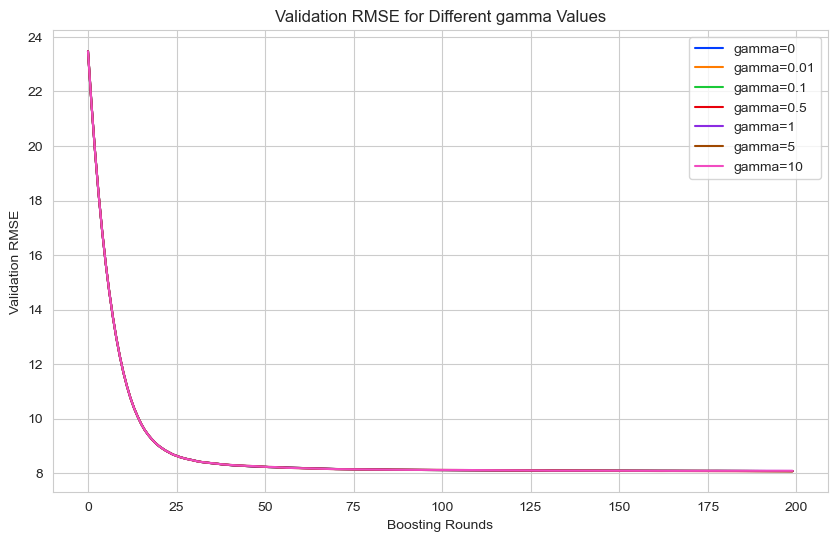

Final RMSE for gamma=0: 8.077346964432435
Final RMSE for gamma=0.01: 8.077346964432435
Final RMSE for gamma=0.1: 8.076397725177742
Final RMSE for gamma=0.5: 8.06914716706811
Final RMSE for gamma=1: 8.08197603783321
Final RMSE for gamma=5: 8.07697089700156
Final RMSE for gamma=10: 8.087833767748014


In [443]:
# Define a function to train models with varying gamma
def train_xgboost_with_gamma(gamma, num_boost_round, eta=0.1, max_depth=6,  min_child_weight=3,  early_stopping_rounds=None):
    xgb_params = {
        'eta': eta,                  
        'max_depth': max_depth,        
        'gamma': gamma,        
        'min_child_weight': min_child_weight,  
        'objective': 'reg:squarederror',
        'nthread': -1,              
        'seed': 1,                   
        'verbosity': 1,                 
        'eval_metric': 'rmse'           
    }

    evals_result = {}

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        verbose_eval=False,  
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result
    )
    
    return evals_result, model

gamma_values = [0, 0.01, 0.1, 0.5, 1, 5, 10]
results_gamma = {}

for gamma in gamma_values:
    evals_result, model = train_xgboost_with_gamma(gamma=gamma, num_boost_round=200)
    results_gamma[gamma] = evals_result

plt.figure(figsize=(10, 6))

for gamma, evals_result in results_gamma.items():
    val_rmse = evals_result['val']['rmse']
    plt.plot(range(len(val_rmse)), val_rmse, label=f'gamma={gamma}')

plt.xlabel('Boosting Rounds')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE for Different gamma Values')
plt.legend()
plt.show()


for gamma, evals_result in results_gamma.items():
    print(f"Final RMSE for gamma={gamma}: {evals_result['val']['rmse'][-1]}")


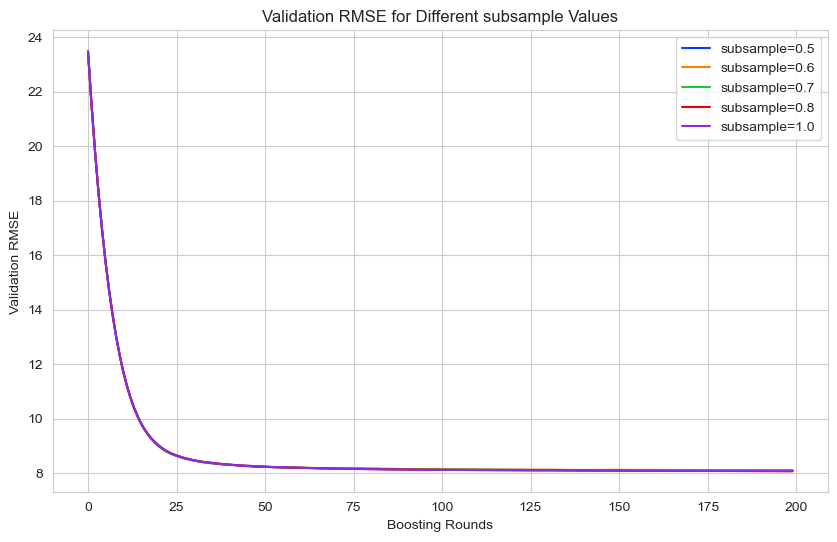

Final RMSE for subsample=0.5: 8.097300544235866
Final RMSE for subsample=0.6: 8.098474390081796
Final RMSE for subsample=0.7: 8.081717867681077
Final RMSE for subsample=0.8: 8.060963853748923
Final RMSE for subsample=1.0: 8.06914716706811


In [444]:
# Define a function to train models with varying subsample
def train_xgboost_with_subsample(subsample, num_boost_round,gamma = 0.5, eta=0.1, max_depth=6,  min_child_weight=3, early_stopping_rounds=None):
    xgb_params = {
        'eta': eta,                     
        'max_depth': max_depth,          
        'gamma': gamma,                
        'subsample': subsample,      
        'min_child_weight': min_child_weight, 
        'objective': 'reg:squarederror', 
        'nthread': -1,                      
        'seed': 1,                    
        'verbosity': 1,                 
        'eval_metric': 'rmse'            
    }

    evals_result = {}

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        verbose_eval=False,  # Suppress output during training
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result
    )
    
    return evals_result, model

# Test different subsample values
subsample_values = [0.5, 0.6, 0.7, 0.8, 1.0]
results_subsample = {}

for subsample in subsample_values:
    evals_result, model = train_xgboost_with_subsample(subsample=subsample, num_boost_round=200)
    results_subsample[subsample] = evals_result

# Plot the RMSE for different subsample values
plt.figure(figsize=(10, 6))

for subsample, evals_result in results_subsample.items():
    val_rmse = evals_result['val']['rmse']
    plt.plot(range(len(val_rmse)), val_rmse, label=f'subsample={subsample}')

plt.xlabel('Boosting Rounds')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE for Different subsample Values')
plt.legend()
plt.show()

# Print final RMSE for each subsample value
for subsample, evals_result in results_subsample.items():
    print(f"Final RMSE for subsample={subsample}: {evals_result['val']['rmse'][-1]}")


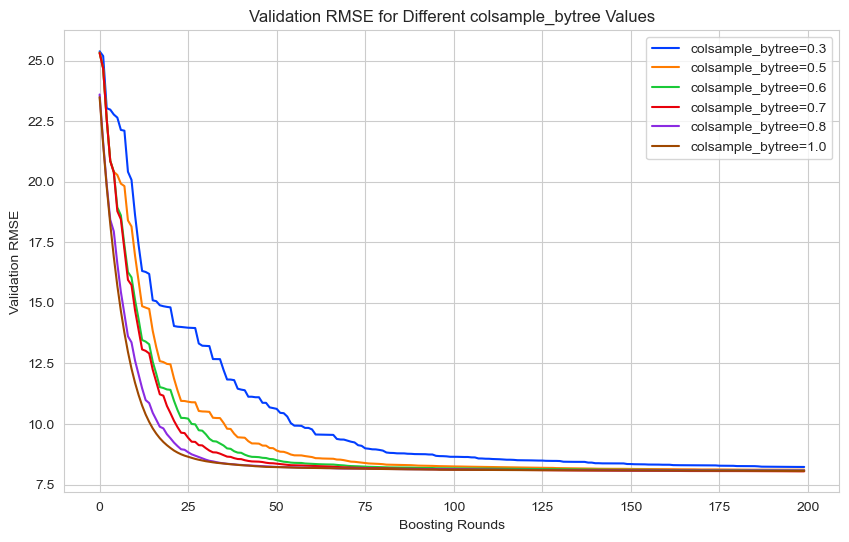

Final RMSE for colsample_bytree=0.3: 8.229276971189384
Final RMSE for colsample_bytree=0.5: 8.116783503744383
Final RMSE for colsample_bytree=0.6: 8.080550328406686
Final RMSE for colsample_bytree=0.7: 8.049033538365288
Final RMSE for colsample_bytree=0.8: 8.080616876771003
Final RMSE for colsample_bytree=1.0: 8.060963853748923


In [446]:
def train_xgboost_with_colsample_bytree(colsample_bytree, num_boost_round, gamma = 0.5, eta=0.1, max_depth=6,  min_child_weight=3, subsample=0.8, early_stopping_rounds=None):
    xgb_params = {
        'eta': eta,                    
        'max_depth': max_depth,         
        'gamma': gamma,                  
        'subsample': subsample,        
        'colsample_bytree': colsample_bytree,  
        'min_child_weight': min_child_weight, 
        'objective': 'reg:squarederror', 
        'nthread': -1,   
        'seed': 1,                 
        'verbosity': 1,                
        'eval_metric': 'rmse'         
    }

    evals_result = {}

    model = xgb.train(
        xgb_params,
        dtrain,
        num_boost_round=num_boost_round,
        evals=watchlist,
        verbose_eval=False,  
        early_stopping_rounds=early_stopping_rounds,
        evals_result=evals_result
    )
    
    return evals_result, model


colsample_bytree_values = [0.3, 0.5, 0.6, 0.7, 0.8, 1.0]
results_colsample_bytree = {}

for colsample_bytree in colsample_bytree_values:
    evals_result, model = train_xgboost_with_colsample_bytree(colsample_bytree=colsample_bytree, num_boost_round=200)
    results_colsample_bytree[colsample_bytree] = evals_result


plt.figure(figsize=(10, 6))

for colsample_bytree, evals_result in results_colsample_bytree.items():
    val_rmse = evals_result['val']['rmse']
    plt.plot(range(len(val_rmse)), val_rmse, label=f'colsample_bytree={colsample_bytree}')

plt.xlabel('Boosting Rounds')
plt.ylabel('Validation RMSE')
plt.title('Validation RMSE for Different colsample_bytree Values')
plt.legend()
plt.show()


for colsample_bytree, evals_result in results_colsample_bytree.items():
    print(f"Final RMSE for colsample_bytree={colsample_bytree}: {evals_result['val']['rmse'][-1]}")


In [447]:
# final model
# Train the final model with optimal hyperparameters
xgb_params = {
    'eta': 0.1,                    
    'max_depth': 6,                
    'gamma': 0.5,                  
    'subsample': 0.8,                
    'colsample_bytree': 0.7,      
    'min_child_weight': 3,         
    'objective': 'reg:squarederror',
    'nthread': -1,             
    'seed': 1,                    
    'verbosity': 1,                
    'eval_metric': 'rmse'          
}

In [448]:
model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=200,  # Maximum boosting rounds
    evals=[(dtrain, 'train'), (dval, 'val')],  # Monitor train and validation RMSE
    verbose_eval=5,  # Print every 5 rounds
    early_stopping_rounds=5  # Stop if no improvement for 10 rounds
)

# Make predictions on the validation set
y_pred = model.predict(dval)

# Calculate RMSE
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Validation RMSE: {rmse}")


[0]	train-rmse:25.33847	val-rmse:25.31229
[5]	train-rmse:18.73293	val-rmse:18.78342


[10]	train-rmse:14.59477	val-rmse:14.69614
[15]	train-rmse:12.08161	val-rmse:12.24108
[20]	train-rmse:10.23837	val-rmse:10.45117
[25]	train-rmse:9.16359	val-rmse:9.43247
[30]	train-rmse:8.69277	val-rmse:9.00460
[35]	train-rmse:8.36818	val-rmse:8.71536
[40]	train-rmse:8.18258	val-rmse:8.55061
[45]	train-rmse:8.05724	val-rmse:8.44756
[50]	train-rmse:7.95389	val-rmse:8.36356
[55]	train-rmse:7.86614	val-rmse:8.29603
[60]	train-rmse:7.82315	val-rmse:8.27373
[65]	train-rmse:7.77339	val-rmse:8.24494
[70]	train-rmse:7.72173	val-rmse:8.20855
[75]	train-rmse:7.68215	val-rmse:8.18639
[80]	train-rmse:7.64811	val-rmse:8.17090
[85]	train-rmse:7.61916	val-rmse:8.15749
[90]	train-rmse:7.58960	val-rmse:8.14770
[95]	train-rmse:7.56061	val-rmse:8.13379
[100]	train-rmse:7.54149	val-rmse:8.12538
[105]	train-rmse:7.52313	val-rmse:8.11862
[110]	train-rmse:7.50425	val-rmse:8.11172
[115]	train-rmse:7.48899	val-rmse:8.10956
[120]	train-rmse:7.47507	val-rmse:8.10569
[125]	train-rmse:7.45649	val-rmse:8.10175
[130

/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [450]:

model = xgb.train(
    xgb_params,
    dtrain,
    num_boost_round=171
)

y_pred = model.predict(dval)

# Calculate RMSE
rmse = mean_squared_error(y_val, y_pred, squared=False)
print(f"Final Validation RMSE: {rmse}")


Final Validation RMSE: 8.061869287564054


/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(


In [451]:
# Make predictions on the test set with full training data
dtest = xgb.DMatrix(X_test, feature_names=features)
y_pred = model.predict(dtest)

# Calculate RMSE
rmse = mean_squared_error(y_test, y_pred, squared=False)
print(f"Test RMSE: {rmse}") 

Test RMSE: 9.039657875145934


/opt/anaconda3/envs/ml-zoomcamp/lib/python3.11/site-packages/sklearn/metrics/_regression.py:492: FutureWarning: 'squared' is deprecated in version 1.4 and will be removed in 1.6. To calculate the root mean squared error, use the function'root_mean_squared_error'.
  warnings.warn(
